## 0. Set google drive (Important!)

The notebook assumes there is an updated copy of source code available in google drive. The path is proviede below:

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
# working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'

os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 Installation

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations

# Liveloss plot utility to watch train/validation loss in realtime
!pip install -q livelossplot
!pip install -q onedrivedownloader nibabel google-cloud-storage MedPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

### 1.2 Imports

In [ ]:
import os
import random

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision.transforms as transforms

from livelossplot import PlotLosses
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (MaskFormerForInstanceSegmentation,
                          MaskFormerImageProcessor)

#******** TODO: DELETE this part when modules are finalized *********#
# rerun everytime changes are made to the modules
import importlib
import utils.data_handler as dh
import utils.maskformer_dataset as mf_d
import utils.maskformer_evaluation as mf_ev
import utils.maskformer_inference as mf_inf
import utils.maskformer_utils as mf_utils
import utils.metrics as metrics
import utils.mri_common as mri_common

importlib.reload(mf_utils)
importlib.reload(mri_common)
importlib.reload(metrics)
importlib.reload(mf_d)
importlib.reload(dh)
importlib.reload(mf_inf)
importlib.reload(mf_ev)
#******************************************************************#

# local imports
import utils.mri_common as mri_common
import utils.maskformer_utils as mf_utils
import utils.maskformer_inference as mf_inf
import utils.metrics as metrics

from utils.maskformer_dataset import MaskformerMRIDataset, collate_fn
from utils.maskformer_evaluation import MaskFormerEvaluation
from utils.maskformer_inference import MaskFormerInference
from utils.data_handler import DataHandler, MriType

np.set_printoptions(precision=16)

# seeding
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)

### 1.3 Initializations (important!)

In [ ]:
data_handler = DataHandler()

# this will dynamically create a new training directory folder with format maskformer/{unix_date}
def create_train_dir_by_date():
  now = str(int( time.time() ))
  return os.path.join("maskformer", now)

In [ ]:
# training variables:
RETRAIN = False
train_dir_prefix = "maskformer/keith"

# load existing model:
LOAD_MODEL = True
model_file_name = "model_all_aug_20epoch_better.pt"
model_dir_prefix = "maskformer/keith"

# variables for calculating metrics
RECALCULATE_TRAIN_METRICS = True
RECALCULATE_VAL_METRICS = True
metrics_dir_prefix = "maskformer/keith"
train_metrics_file_name = "metrics_train_all_aug_20epoch_jul14.joblib"
val_metrics_file_name = "metrics_val_all_aug_20epoch_jul14.joblib"

# training resolution
#height, width = 163, 193    #original dimensions
#height, width = 489, 579    #3x
height, width = 512, 512
#height, width = 652, 772    #4x
#height, width = 815, 965    #5x
#height, width = 897, 1062   #5.5x
#height, width = 978, 1158   #6x

In [ ]:
# this part will check if the directory already exists and whether the person intends to overwrite the files in that train directory
dir_exists = data_handler.dir_exists(train_dir_prefix=train_dir_prefix)
if dir_exists:
  answer = input(f"Chosen train_dir_prefix {train_dir_prefix} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer.lower() not in ["yes", "y"]:
    print("Dynamically creating a new training directory...")
    train_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using training_dir_prefix: {train_dir_prefix}")

Chosen train_dir_prefix maskformer/keith has files stored. 
Are you sure you want to overwrite this folder? Reply YES: YES

Files will be saved using training_dir_prefix: maskformer/keith


In [ ]:
# this part will check if the directory already exists and whether the person intends to overwrite the files in that metrics directory
dir_exists = data_handler.dir_exists(train_dir_prefix=metrics_dir_prefix)
if dir_exists:
  answer = input(f"Chosen metrics_dir_prefix {metrics_dir_prefix} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer.lower() not in ["yes", "y"]:
    print("Dynamically creating a new metrics directory...")
    metrics_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using metrics_dir_prefix: {metrics_dir_prefix}")

Chosen metrics_dir_prefix maskformer/keith has files stored. 
Are you sure you want to overwrite this folder? Reply YES: YES

Files will be saved using metrics_dir_prefix: maskformer/keith



## 2. Process 2D data

### 2.1 load and select data

In [ ]:
# set file names
train_list_full = "data_train_all.txt"
val_list_full   = "data_val_all.txt"
train_list = "data_train.txt"
val_list   = "data_val.txt"

#### Using below if use all data

In [ ]:
# train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D_CROSS)
# train_files_unique = [mri_common.get_mri_slice_file_name(file_name) for file_name in train_2d]
# train_files_unique = list(set(train_files_unique))
# train_files_unique.sort()
# print(f"Number of unique training samples: {len(train_files_unique)}")
# data_handler.save_text(file_name = train_list,
#                        train_dir_prefix=train_dir_prefix,
#                        data='\n'.join(str(item) for item in train_files_unique))


# val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D_CROSS)
# val_files_unique = [mri_common.get_mri_slice_file_name(file_name) for file_name in val_2d]
# val_files_unique = list(set(val_files_unique))
# val_files_unique.sort()
# print(f"Number of unique validation samples: {len(val_files_unique)}")
# data_handler.save_text(file_name = val_list,
#                        train_dir_prefix=train_dir_prefix,
#                        data='\n'.join(str(item) for item in val_files_unique))

#### **Testing:** Using a small portion of data for efficient testing

In [ ]:
# list files from Training and Validation folder
train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D)
val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D)

# save if files do not exist yet
train_file_exists = data_handler.file_exists(train_dir_prefix=train_dir_prefix, file_name = train_list_full)
if not train_file_exists:
    data_handler.save_text(file_name = train_list_full,
                        train_dir_prefix=train_dir_prefix,
                        data='\n'.join(str(item) for item in train_2d))

val_file_exists = data_handler.file_exists(train_dir_prefix=train_dir_prefix, file_name = val_list_full)
if not val_file_exists:
    data_handler.save_text(file_name = val_list_full,
                        train_dir_prefix=train_dir_prefix,
                        data='\n'.join(str(item) for item in val_2d))

In [ ]:
# select slice range
n_total = 146
file_no_min = n_total//2 - 20
file_no_max = n_total//2 + 20
#file_no_min = 0
#file_no_max = n_total + 1

# select patent id range
subj_total = 88
subj_id_min = 0
subj_id_max = subj_total + 1

# define train and validation dataset
# obtain all train files
subj_train_files = data_handler.load_text_as_list(file_name=train_list_full,
                                                  train_dir_prefix=train_dir_prefix)

# obtain subset of files
train_data_list = mf_utils.get_subset_files(subj_train_files, file_no_min, file_no_max, subj_id_min, subj_id_max)
data_handler.save_text(file_name = train_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in train_data_list))

print(f"Number of unique training samples: {len(train_data_list)}")


# do same for validation
subj_val_files = data_handler.load_text_as_list(file_name=val_list_full,
                                                train_dir_prefix=train_dir_prefix)

val_data_list = mf_utils.get_subset_files(subj_val_files, file_no_min, file_no_max, subj_id_min, subj_id_max)
data_handler.save_text(file_name = val_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in val_data_list))
print(f"Number of unique validation samples: {len(val_data_list)}")

Number of unique training samples: 3520
Number of unique validation samples: 1200


### 2.2 Create Custom PyTorch Dataset


In [ ]:
# set maskformer processor
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
# processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)


In [ ]:
# load list from text file saved from 2.1
train_data_list = data_handler.load_text_as_list(file_name = train_list, train_dir_prefix=train_dir_prefix)
val_data_list = data_handler.load_text_as_list(file_name = val_list, train_dir_prefix=train_dir_prefix)

# define data transoforms
train_transform = A.Compose([
    # A.Resize(width=146, height=193),
    # A.Resize(width=193, height=163),
    A.Resize(width=width, height=height),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

# create datasets
train_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MriType.TRAIN_2D, data_list=train_data_list, processor=processor, transform=train_transform, augment=True)
val_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MriType.VAL_2D, data_list=val_data_list, processor=processor, transform=train_transform, augment=False)

# setup data loader
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### 2.3 QC dataset

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])
3520
tensor([0, 1, 2, 3])


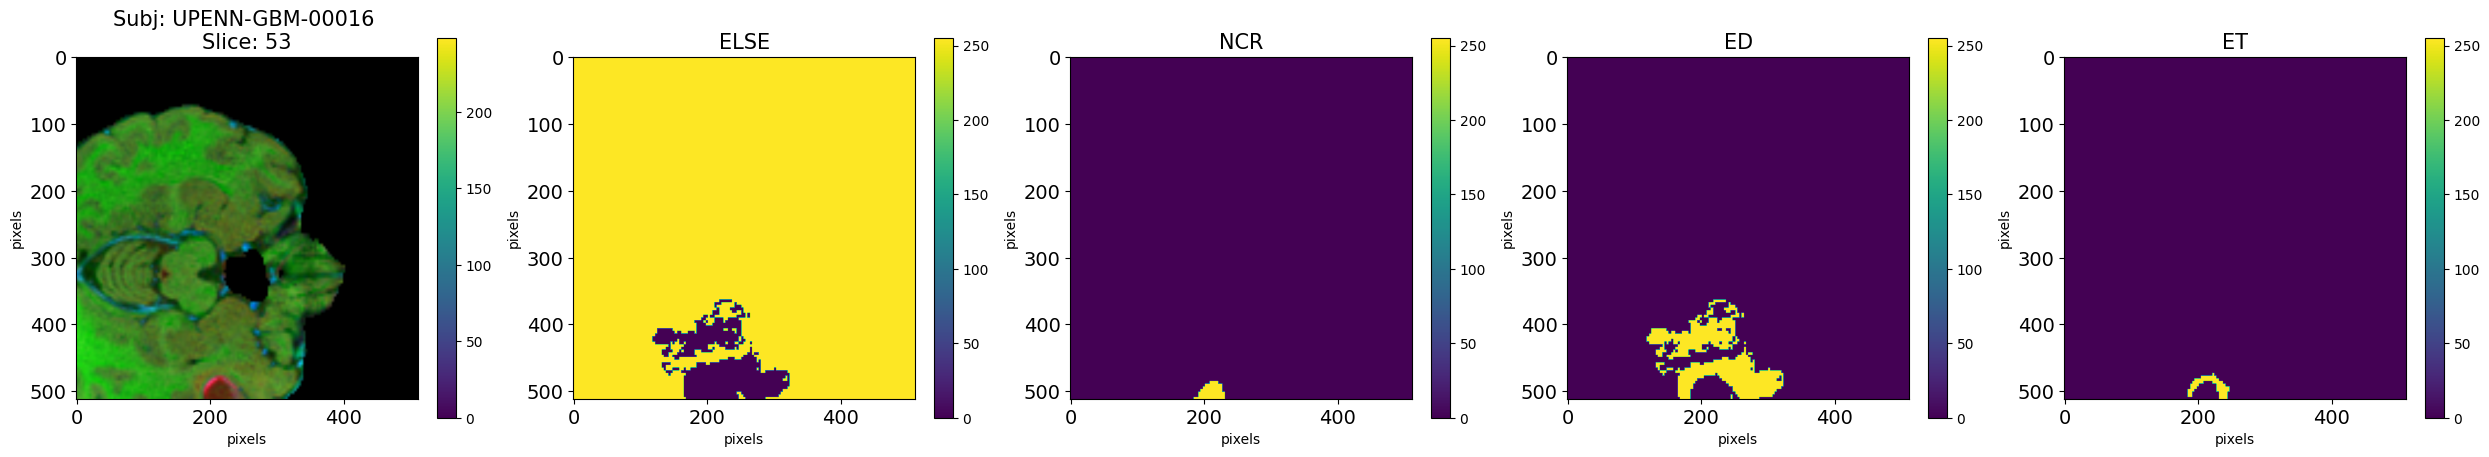

In [ ]:
# peek at the train dataset
train_input = train_dataset[120]
for k,v in train_input.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(train_dataset))
print(train_input["class_labels"])

train_img_title = f"Subj: {train_input['subj_no']} \nSlice: {train_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=train_input["class_labels"].tolist(),
             pixel_values = train_input['pixel_values'].numpy(),
             mask_labels = train_input['mask_labels'],
             title = train_img_title)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([1, 512, 512])
class_labels torch.Size([1])
1200
tensor([0])


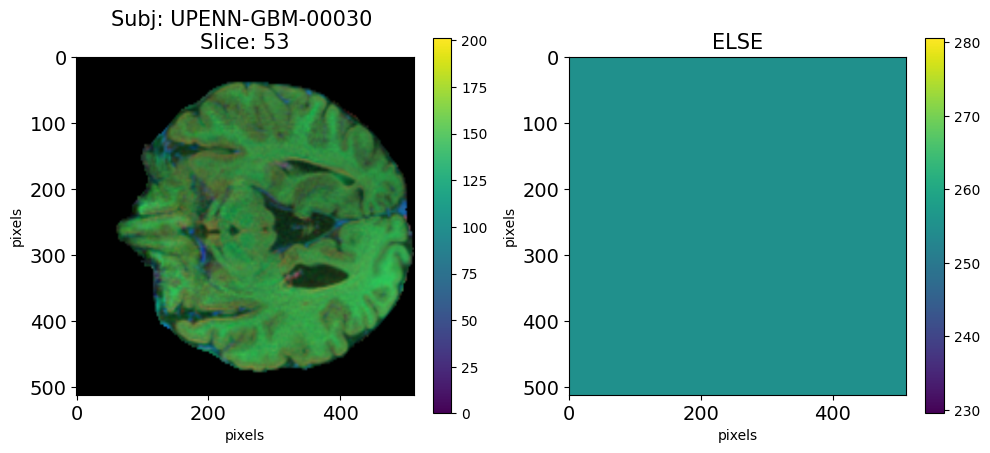

In [ ]:
# peek at the val dataset
val_input = val_dataset[120]
for k,v in val_input.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(val_input["class_labels"])

# plot val dataset
val_img_title = f"Subj: {val_input['subj_no']} \nSlice: {val_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=val_input["class_labels"].tolist(),
             pixel_values = val_input['pixel_values'].numpy(),
             mask_labels = val_input['mask_labels'],
             title= val_img_title)

## 3. Fine-tuning Model

### 3.1 Define the model

In [ ]:
# Make label dictionary
id2label = mri_common.SEGMENTS.copy()
print(id2label)

label2id = {}
for key, value in id2label.items():
    label2id[value] = key
print(label2id)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("zuppif/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)


{0: 'ELSE', 1: 'NCR', 2: 'ED', 3: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 3}


Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at zuppif/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# load saved model if needed
if LOAD_MODEL == True:
  model = data_handler.load_torch_model(file_name=model_file_name, train_dir_prefix=model_dir_prefix, device=device)

In [ ]:
# add outputs
# model.config.decoder_config.output_attentions = True
# model.config.decoder_config.output_hidden_states = True
# model.config.decoder_config.output_scores = True
model.config.output_attentions = True
# model.config.output_hidden_states = True

# reset weight of losses
# model.config.mask_weight  = 2.0
# model.config.dice_weight = 0.1
# model.config.cross_entropy_weight  = 10000.0
# model.config.use_auxiliary_loss = False
# model.config.ce_weight = 10000.0

# print model config
configuration = model.config
print(configuration)

MaskFormerConfig {
  "_commit_hash": "2414a16c60f1463efcba694a0b4ff6b8a764a4cf",
  "_name_or_path": "zuppif/maskformer-swin-base-ade",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "depths": [
      2,
      2,
      18,
      2
    ],
    "diversity_penalty": 0.0,
    "do_sample": false,
    "drop_path_rate": 0.3,
    "early_stopping": false,
    "embed_dim": 128,
    "encoder_no_repeat_ngram_size": 0,
    "encoder_stride": 32,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
 

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, width, height), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
MaskFormerForInstanceSegmentation (MaskFormerForInstanceSegmentation)                           [2, 3, 512, 512]     [2, 8, 100, 100]     --                   True
├─MaskFormerModel (model)                                                                       [2, 3, 512, 512]     [2, 8, 100, 100]     --                   True
│    └─MaskFormerPixelLevelModule (pixel_level_module)                                          [2, 3, 512, 512]     --                   --                   True
│    │    └─MaskFormerSwinBackbone (encoder)                                                    [2, 3, 512, 512]     [2, 128, 128, 128]   86,882,424           True
│    │    └─MaskFormerPixelDecoder (decoder)                                                    [2, 128, 128, 128]   --                   4,951,808            True
│    └─Mask

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.2 Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [ ]:
# obtain a batch of data
batch = next(iter(train_dataloader))

model.to(device)

outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )
loss_init = outputs.loss.item()

# print basic info
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

# print some info
print([label.shape for label in batch["class_labels"]])
print([label.shape for label in batch["mask_labels"]])

# print loss
print('Initial Loss is:', loss_init)


pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2
subj_no 2
file_no 2
[torch.Size([2]), torch.Size([4])]
[torch.Size([2, 512, 512]), torch.Size([4, 512, 512])]
Initial Loss is: 0.15165643393993378


### 3.3 Train the model

In [ ]:
# TODO: move this to a train function and parameterize hyperparameters

if RETRAIN:

    liveloss = PlotLosses()

    batch_max = 100000
    loss_train = []
    loss_val = []
    min_loss = 1e9
    # mutiplier is used to scale loss values to be more readable
    loss_multiplier = 10.0

    # define number of epochs in training
    n_epoch = 10

    # saving model half way
    SAVE_INT = n_epoch // 2

    # define learning rate
    # lr = 2e-5
    lr = 1e-5
    # lr = 0.5e-5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print( 'Initial loss is {:10.6f}.'.format(round(loss_init, 6)*loss_multiplier) )
    logs = {}
    # logs['loss'] = loss_init
    # logs['val_loss'] = loss_init

    # liveloss.update(logs)
    # liveloss.send()

    for epoch in range(1,n_epoch+1):
        print("Starting Epoch:", epoch)

        ## training loop
        running_loss = 0.0
        num_samples = 0
        model.train()
        for ibatch, batch in enumerate(tqdm(train_dataloader)):
            # run partial data based on input limit
            if ibatch < batch_max:
                # Reset the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(
                        pixel_values=batch["pixel_values"].to(device),
                        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                        class_labels=[labels.to(device) for labels in batch["class_labels"]],
                )

                # Backward propagation
                loss = outputs.loss * loss_multiplier
                loss.backward()

                batch_size = batch["pixel_values"].size(0)
                running_loss += loss.item()
                num_samples += batch_size
                loss_train_cur = running_loss/num_samples

                # Optimization
                optimizer.step()
            else:
                # skip where ibatch >= batch_max
                break

        # record loss at the end of each epoch
        logs['loss'] = loss_train_cur
        print( 'Epoch {:<4} training loss is: {:8.6f}.'.format(epoch, round(loss_train_cur, 6)) )
        loss_train.append(loss_train_cur)

        ## validation loop
        running_loss = 0.0
        num_samples = 0
        model.eval()
        with torch.no_grad():
            for ibatch, batch in enumerate(tqdm(val_dataloader)):
                # run partial data based on input limit
                if ibatch < batch_max:
                    # Forward pass
                    outputs = model(
                            pixel_values=batch["pixel_values"].to(device),
                            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                            class_labels=[labels.to(device) for labels in batch["class_labels"]],
                    )

                    # loss
                    loss = outputs.loss  * loss_multiplier

                    batch_size = batch["pixel_values"].size(0)
                    running_loss += loss.item()
                    num_samples += batch_size
                    loss_val_cur = running_loss/num_samples
                else:
                    # skip where ibatch >= batch_max
                    break

        # record loss at the end of each epoch
        logs['val_loss'] = loss_val_cur
        # print( 'Epoch {:<4} validation loss is: {:8.6f}.'.format(epoch, round(loss_val_cur, 6)) )
        loss_val.append(loss_val_cur)

        # if found better model, update min_loss and save model (currently using training loss)

        if min_loss > loss_val_cur:
            print("Saved model in epoch",epoch)
            # save the best model
            # data_handler.save_torch_model(file_name="model_current.pt", train_dir_prefix=train_dir_prefix, model=model)
            min_loss = loss_val_cur

        # save model regularly
        if epoch%SAVE_INT == 0:
            print("Saved model in epoch",epoch)

            # save the best model
            data_handler.save_torch_model(file_name='model_epoch'+str(epoch)+'.pt', train_dir_prefix=train_dir_prefix, model=model)

        # Update the plot with new logging information.
        liveloss.update(logs)
        liveloss.send()

    # save loss at the end
    data_handler.save_torch_model(file_name='losses_train_current.pt', train_dir_prefix=train_dir_prefix, model=loss_train)
    data_handler.save_torch_model(file_name='losses_val_current.pt', train_dir_prefix=train_dir_prefix, model=loss_val)

## 4. Evaluation

### 4.1 Make prediction on one sample

#### 4.1.0 Initialize Functions

In [ ]:
# will be passed to the prediction function so it knows the model, processor and transform to use
mf_inference=MaskFormerInference(data_handler=data_handler, model=model, processor=processor, transform=train_transform)

#### 4.1.1 Model prediction and visualization on one sample

In [ ]:
# create a test data loader without shuffling
QC_TYPE = 'val'
batch_size = 2
if QC_TYPE == 'train':
    qc_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
else:
    qc_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# obtain one batch of data
target_batch = 6
for ibatch, batch in enumerate(qc_dataloader):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

test_idx = 1

test_image =  test_batch["pixel_values"][test_idx]
test_pixel_mask = test_batch["pixel_mask"][test_idx]
test_mask_labels = test_batch["mask_labels"][test_idx]
test_class_labels = test_batch["class_labels"][test_idx]
test_subj = test_batch["subj_no"][test_idx] + "_" +  test_batch["file_no"][test_idx]

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2
subj_no 2
file_no 2


In [ ]:
# load one batch of data and make predictions
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(
            pixel_values=test_image.unsqueeze(0).to(device),
            mask_labels=[test_mask_labels.to(device)],
            class_labels=[test_class_labels.to(device)],
        )

torch.cuda.empty_cache()

# post-processing of output
target_size = transforms.ToPILImage()(test_image).size[::-1]
print("target size", target_size)
results = processor.post_process_instance_segmentation(outputs, target_sizes=[target_size])[0]

print("segments info", results['segments_info'])
print("test image shape", test_image.shape)
print("segmentation result shape", results['segmentation'].shape)

target size (512, 512)
segments info [{'id': 0, 'label_id': 0, 'was_fused': False, 'score': 0.993238}, {'id': 1, 'label_id': 2, 'was_fused': False, 'score': 0.881603}, {'id': 2, 'label_id': 3, 'was_fused': False, 'score': 0.886761}, {'id': 3, 'label_id': 1, 'was_fused': False, 'score': 0.807745}]
test image shape torch.Size([3, 512, 512])
segmentation result shape torch.Size([512, 512])


In [ ]:
# Obtain labels in true, predict, intersection and union
labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )

# remove duplicates
labels_pred = list(set(labels_pred))
labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:",labels_all)
print("Common labels:",labels_common)

True labels: ['ELSE', 'NCR', 'ED', 'ET']
Predicted labels: ['ET', 'ELSE', 'ED', 'NCR']
All labels: ['ET', 'NCR', 'ED', 'ELSE']
Common labels: ['ET', 'ELSE', 'ED', 'NCR']


#### 4.1.2 Visualize model output

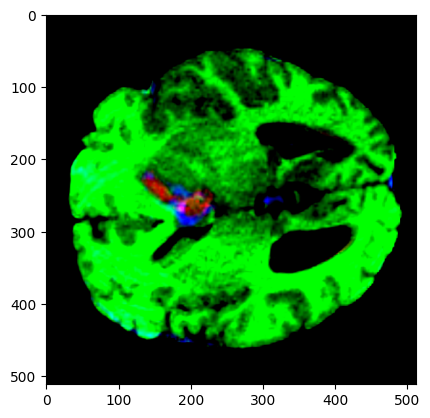

In [ ]:
input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)
plt.show()

In [ ]:
# print information on the output
print('output keys:',outputs.keys())

print('class_queries_logits shape:',outputs.class_queries_logits.shape)
print('masks_queries_logits shape:',outputs.masks_queries_logits.shape)

print('encoder_last_hidden_state shape:',outputs.encoder_last_hidden_state.shape)
print('pixel_decoder_last_hidden_state shape:',outputs.pixel_decoder_last_hidden_state.shape)
print('transformer_decoder_last_hidden_state shape:',outputs.transformer_decoder_last_hidden_state.shape)

print('len(attentions):',len(outputs.attentions))
print('attentions[0]:',outputs.attentions[0].shape)


output keys: odict_keys(['loss', 'class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state', 'attentions'])
class_queries_logits shape: torch.Size([1, 100, 5])
masks_queries_logits shape: torch.Size([1, 100, 128, 128])
encoder_last_hidden_state shape: torch.Size([1, 1024, 16, 16])
pixel_decoder_last_hidden_state shape: torch.Size([1, 256, 128, 128])
transformer_decoder_last_hidden_state shape: torch.Size([1, 100, 256])
len(attentions): 6
attentions[0]: torch.Size([1, 8, 100, 100])


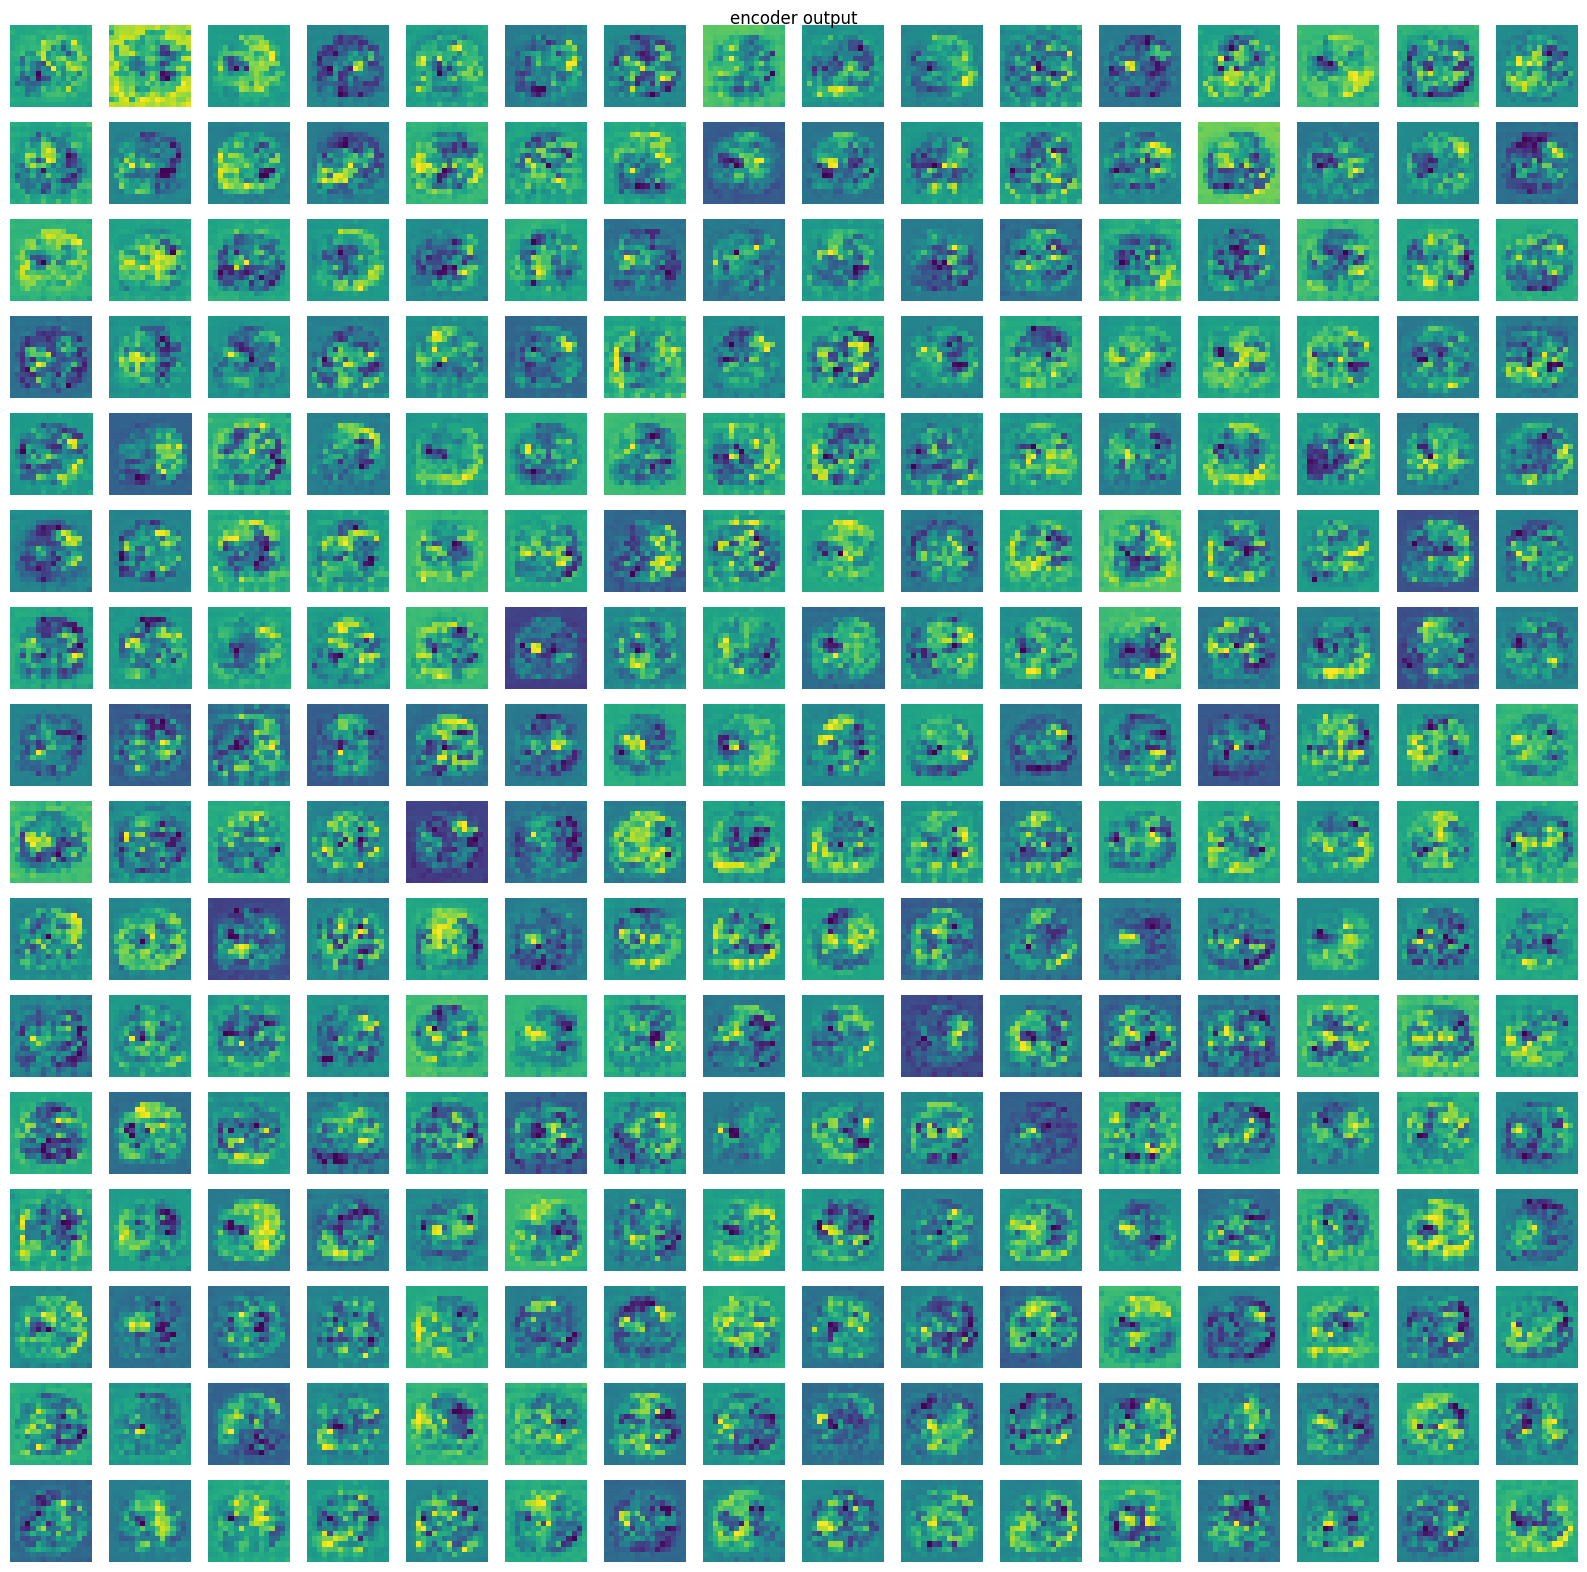

In [ ]:
# visualize the last layer of the encoder

n_row = 32
n_col = 32
n_skip = 2

fig, axs = plt.subplots(nrows=n_row//n_skip, ncols=n_col//n_skip,
                        figsize=(n_col//n_skip, n_row//n_skip))

for irow in range(n_row//n_skip):
    for icol in range(n_col//n_skip):
        idx = (irow*n_skip) * n_col + icol*n_skip
        encoder_last_hidden_state = outputs.encoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('encoder output')
fig.tight_layout()
fig.show()

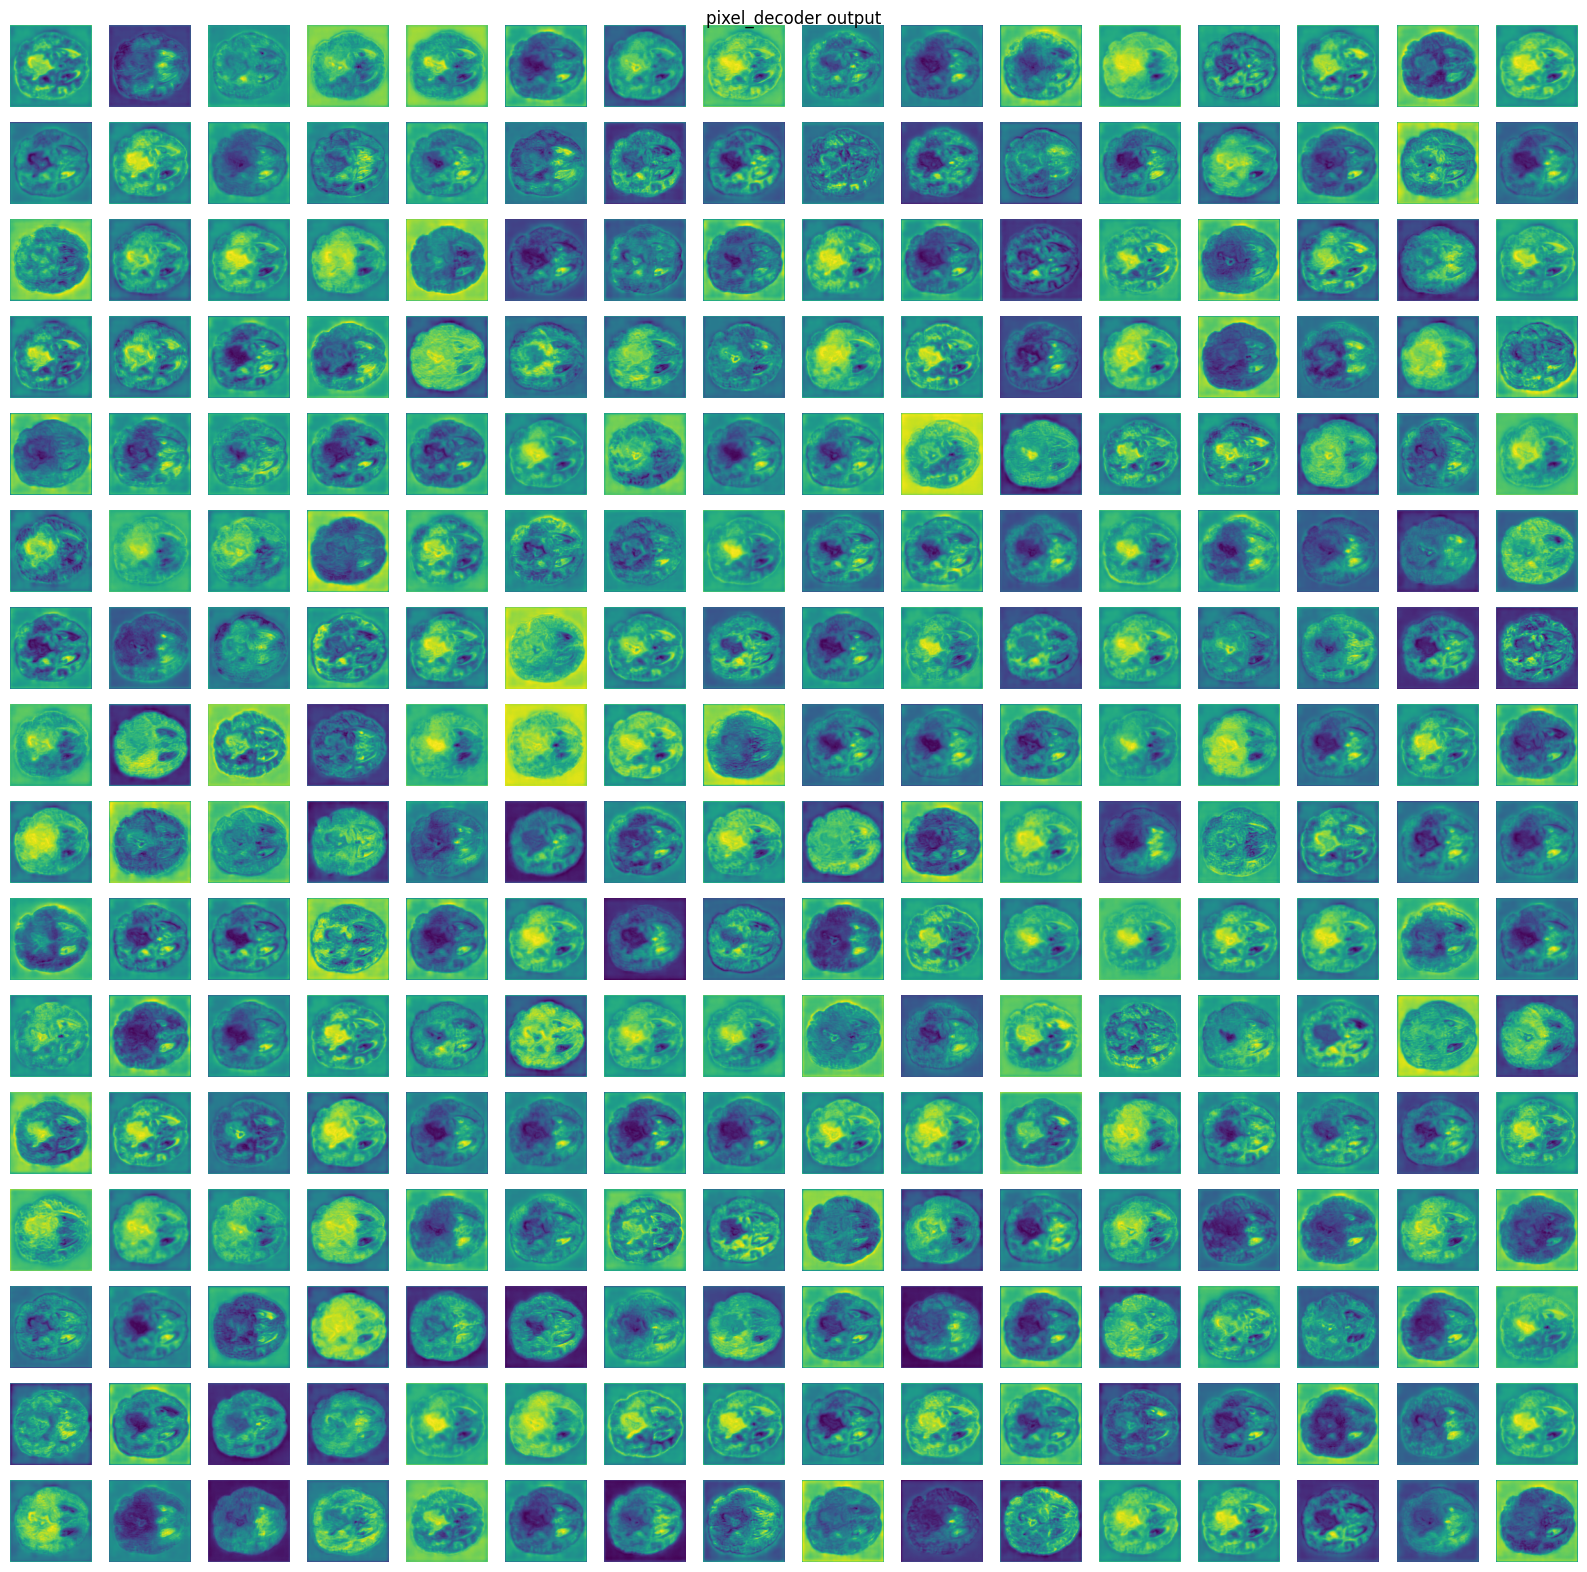

In [ ]:
# visualize the last layer of the pixel decodeer
n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        encoder_last_hidden_state = outputs.pixel_decoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('pixel_decoder output')
fig.tight_layout()
plt.show()

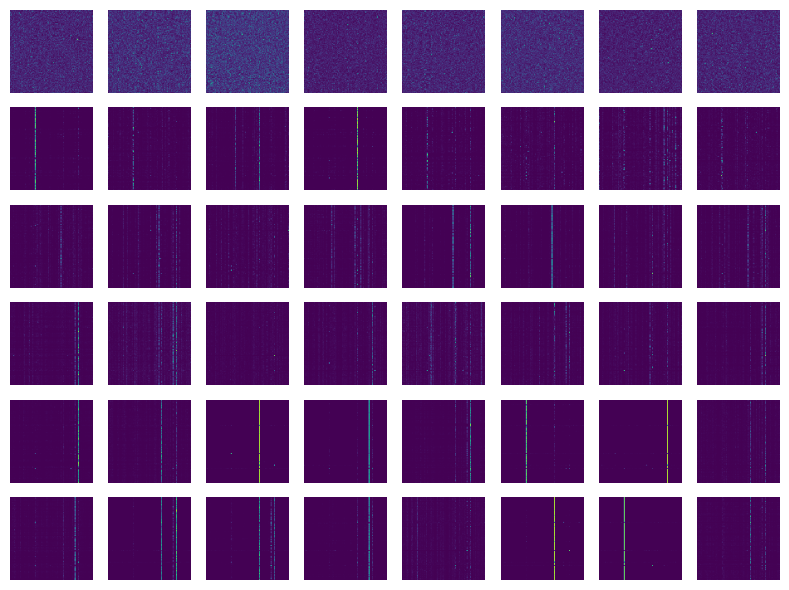

In [ ]:
# visualize the attention map
n_row = 6
n_col = 8

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        attention_test = outputs.attentions[irow][0,icol,:,:].squeeze().detach().cpu().numpy()
        axs[irow,icol].imshow(attention_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

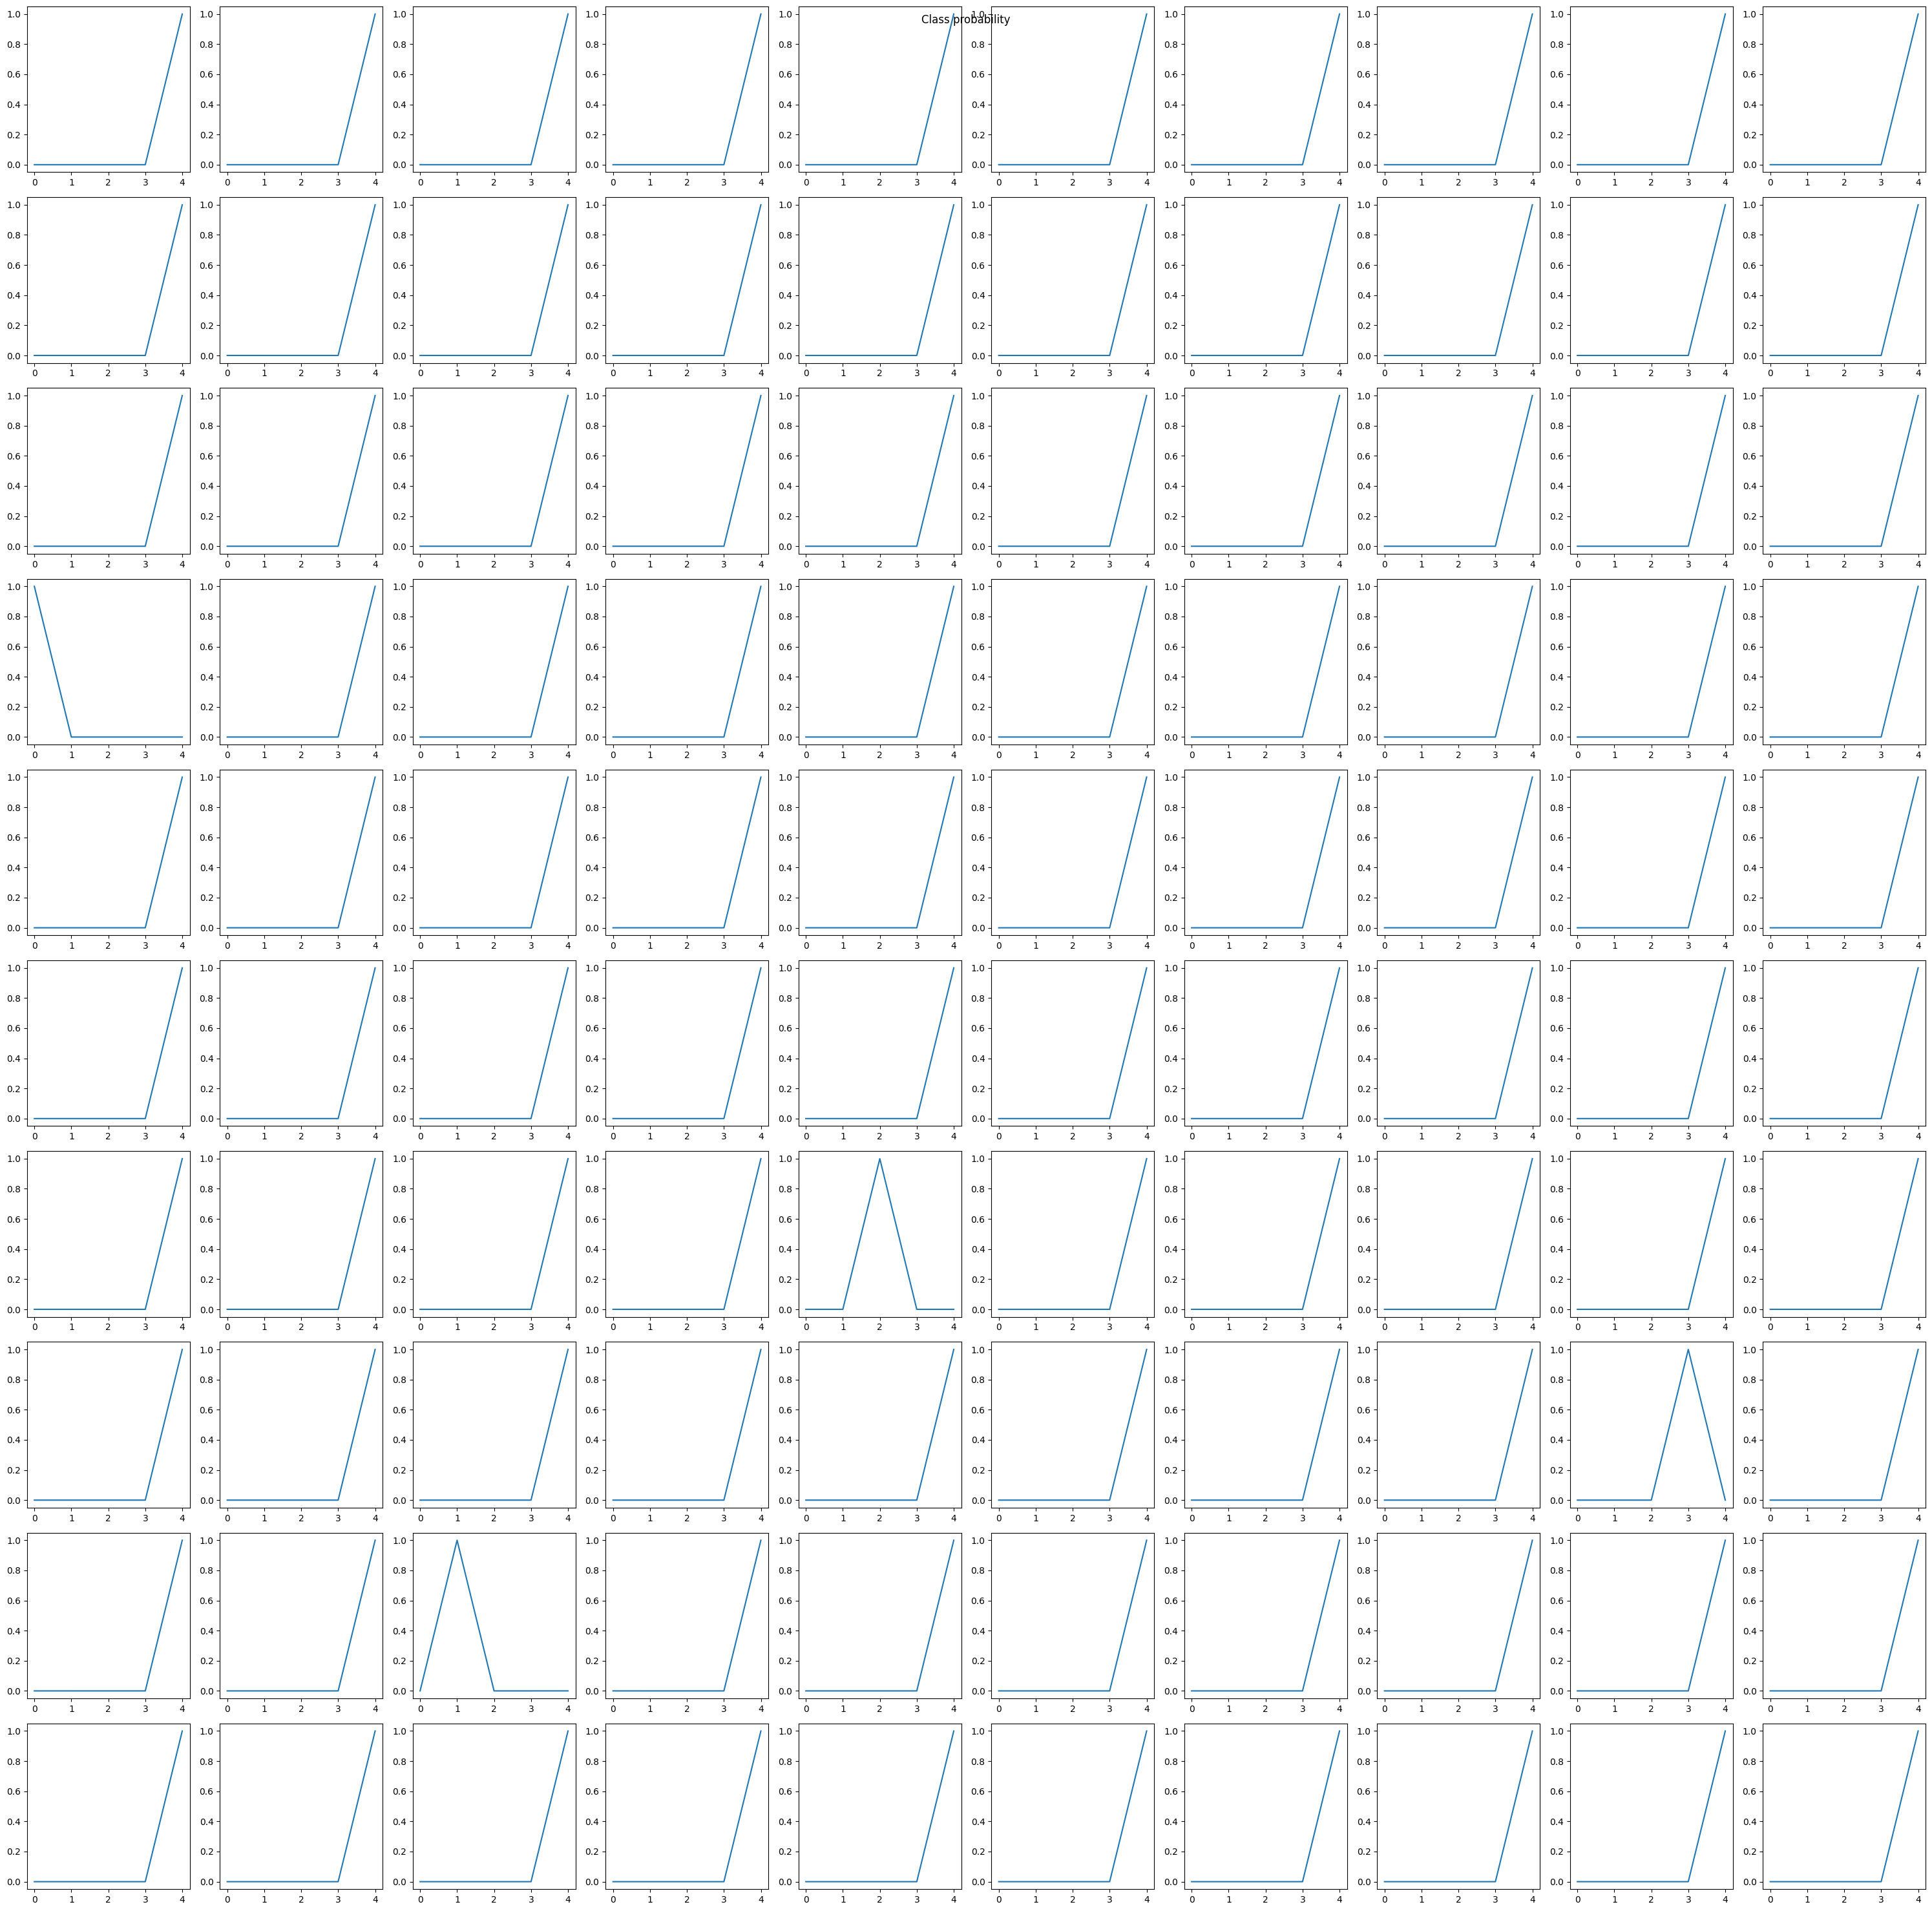

In [ ]:
# compute and visualize class probability prediction

n_row = 10
n_col = 10

class_probs = np.zeros((outputs.class_queries_logits.shape[1], outputs.class_queries_logits.shape[2]))

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        class_queries_logits_test = outputs.class_queries_logits[0,idx,:].squeeze().detach().cpu().numpy()

        class_probs[idx,:] = mf_utils.softmax(class_queries_logits_test)

        axs[irow,icol].plot(class_probs[idx,:])
        # axs[irow,icol].axis('off')

fig.suptitle('Class probability')
fig.tight_layout()
fig.show()

In [ ]:
# compute mask prediction from pixel decoder and transofmrer decoder
# it is a dot product reducing the channel dimmension followed by a sigmoind activation

img_size = outputs.pixel_decoder_last_hidden_state.shape[-1]

# Reshape array1 for matrix multiplication
pixel_decoder_reshaped = outputs.pixel_decoder_last_hidden_state[0,:,:,:].squeeze().detach().cpu().reshape(256, img_size*img_size)
transformer_decoder_reshaped = outputs.transformer_decoder_last_hidden_state[0,:,:].squeeze().detach().cpu().reshape(100, 256)

# Perform matrix multiplication
mask_pred_vis = torch.matmul(transformer_decoder_reshaped, pixel_decoder_reshaped)

# Apply sigmoid function
mask_pred_vis = torch.sigmoid(mask_pred_vis)

# Reshape result to the desired shape
mask_pred_vis = mask_pred_vis.reshape(100, img_size, img_size).numpy()

mask_pred_vis.shape

(100, 128, 128)

In [ ]:
print(pixel_decoder_reshaped.shape)
print(transformer_decoder_reshaped.shape)

torch.Size([256, 16384])
torch.Size([100, 256])


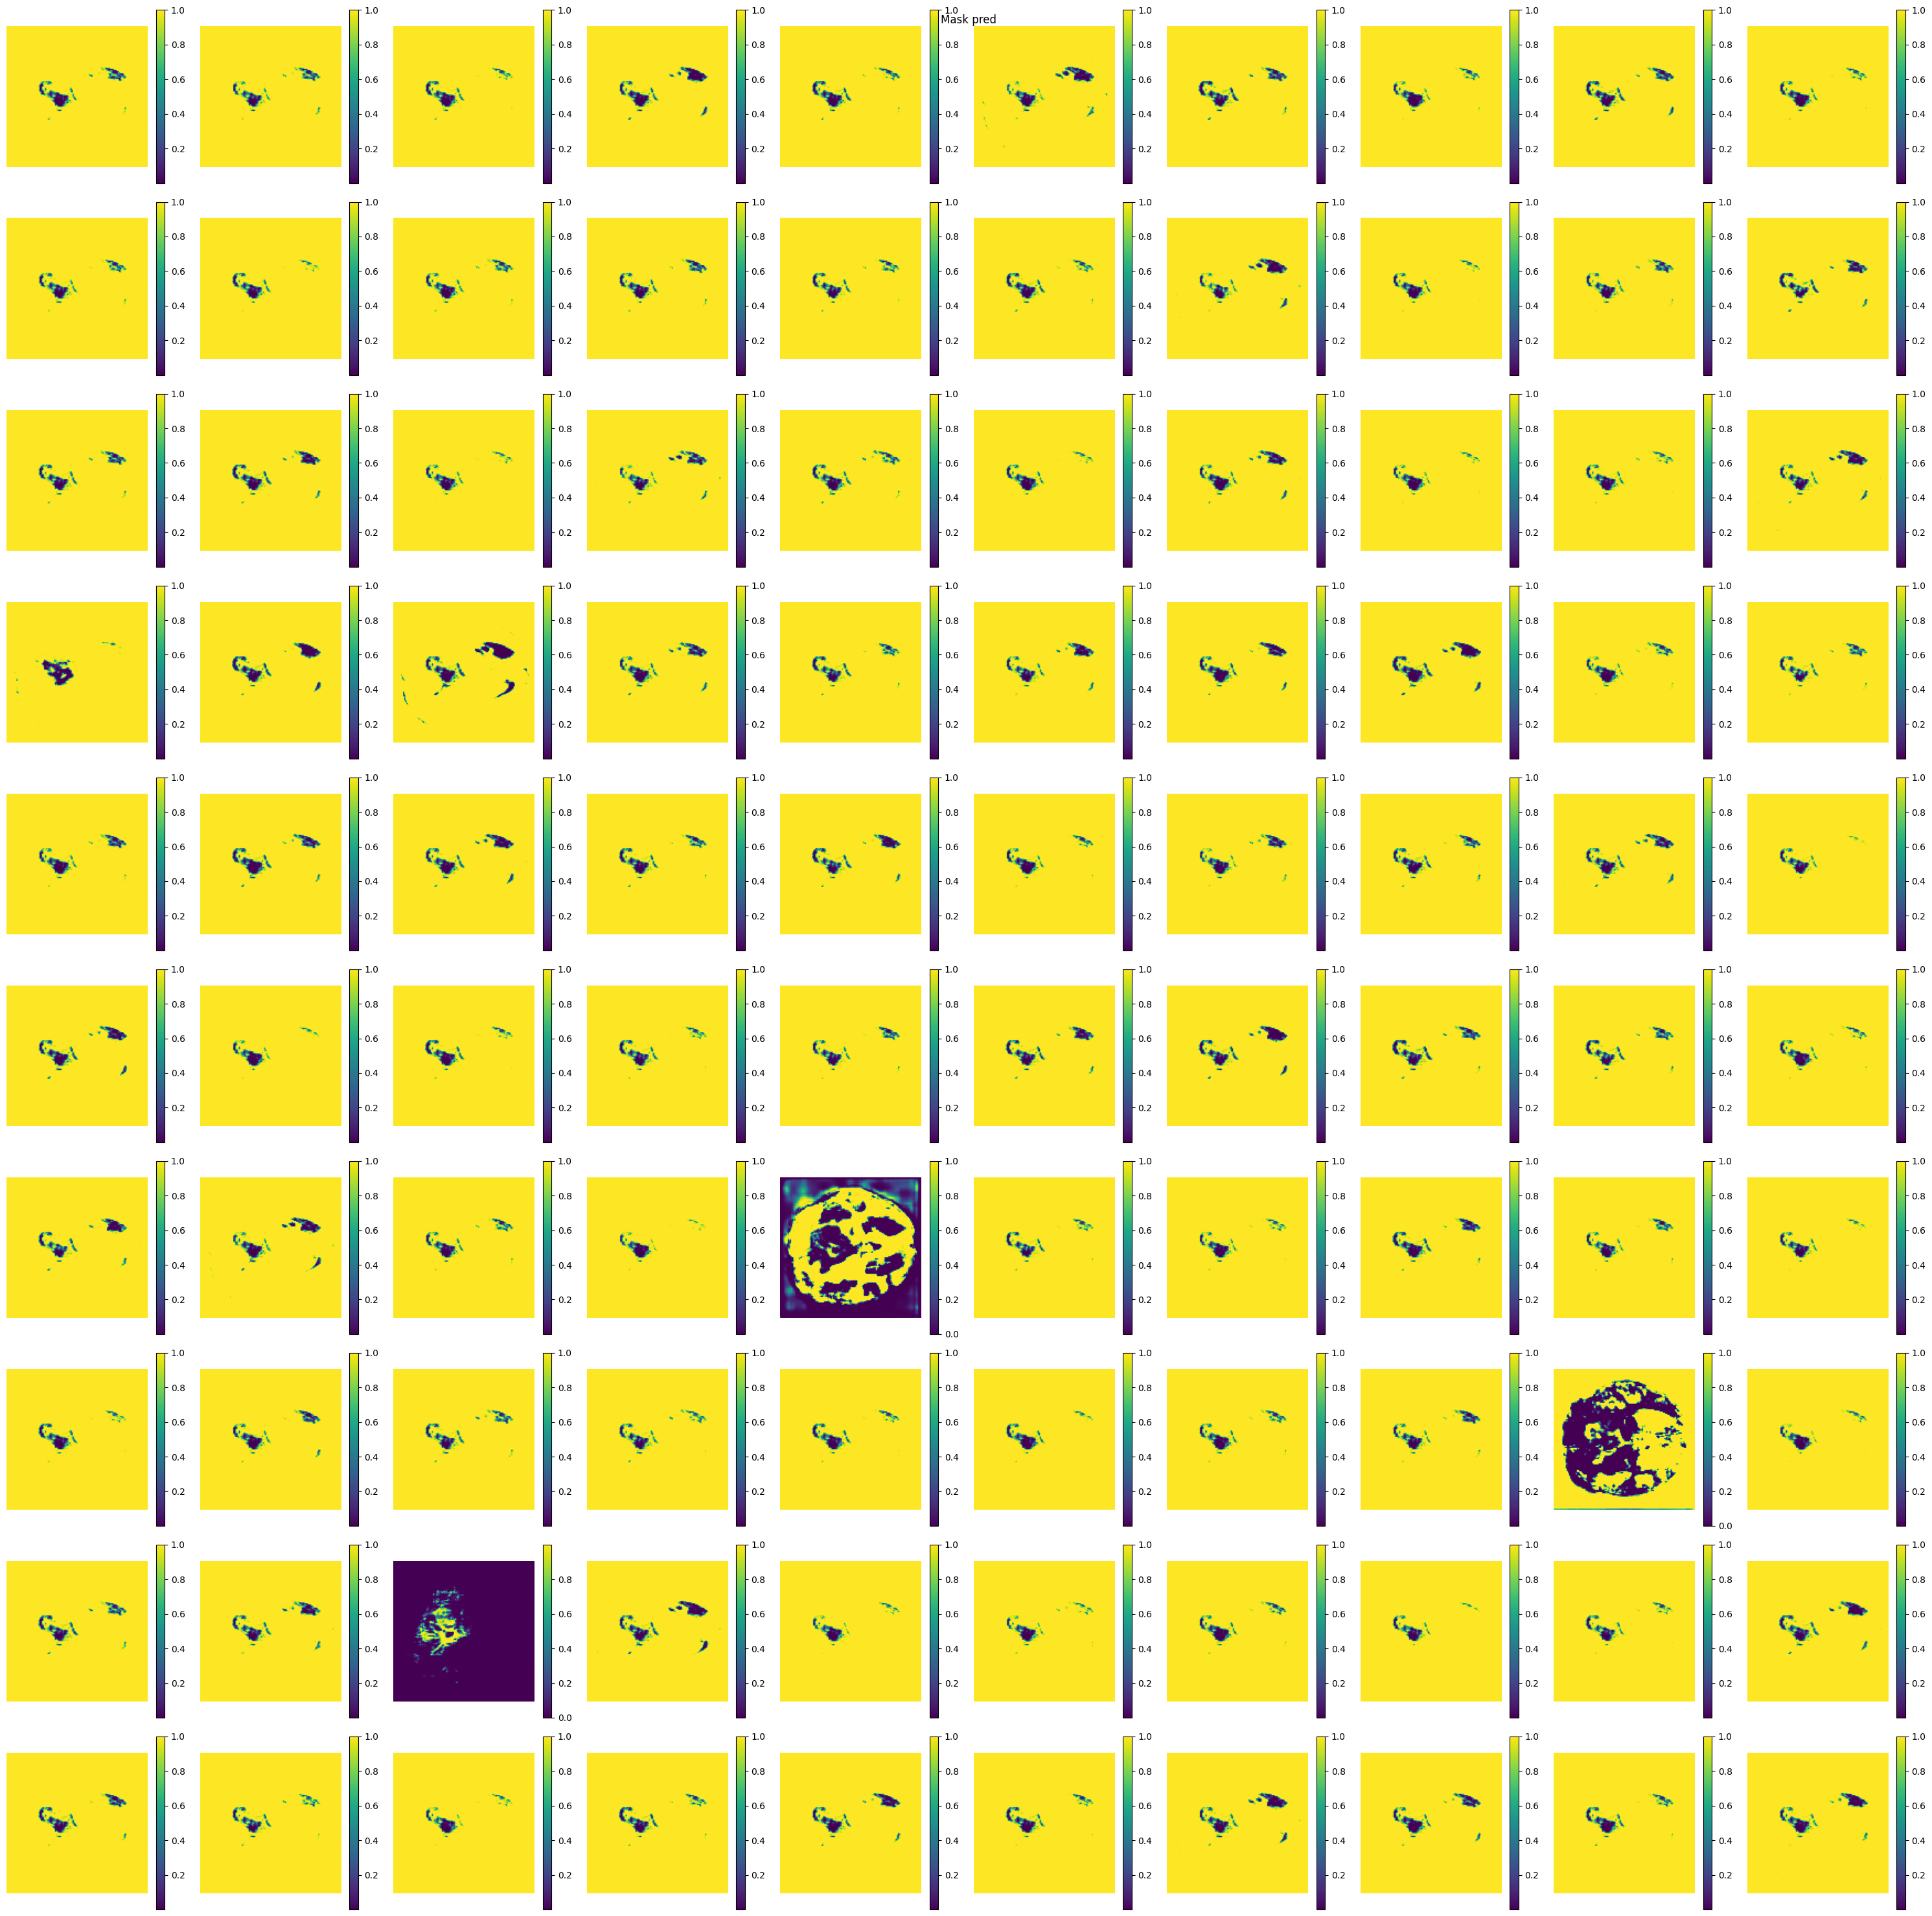

In [ ]:
# visualize mask prediction
n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol

        img = axs[irow,icol].imshow(mask_pred_vis[idx,:,:])
        axs[irow,icol].axis('off')
        fig.colorbar(img, ax=axs[irow,icol])

fig.suptitle('Mask pred')
fig.tight_layout()
fig.show()


torch.Size([128, 128])


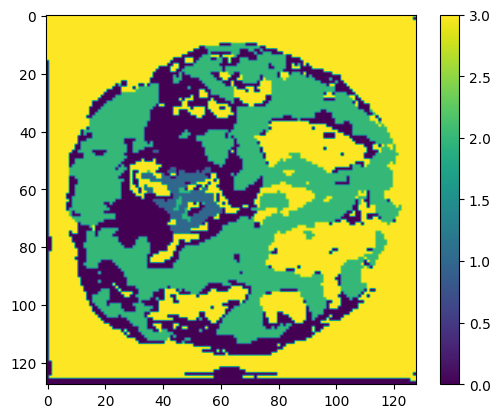

In [ ]:
# Reshape array1 for matrix multiplication
class_probs_tensor = torch.from_numpy(class_probs).double()
mask_pred_tensor = torch.from_numpy(mask_pred_vis).double()

matrix1 = class_probs_tensor.permute(1, 0)
matrix2 = mask_pred_tensor.reshape(100, img_size*img_size)

matrix_out = torch.matmul(matrix1, matrix2).reshape(5,img_size,img_size)

result = torch.argmax(matrix_out[:-1,:,:], dim=0)

print(result.shape)

plt.imshow(result)
plt.colorbar()
plt.show()

#### 4.1.3 Visualize QC Predicted Mask

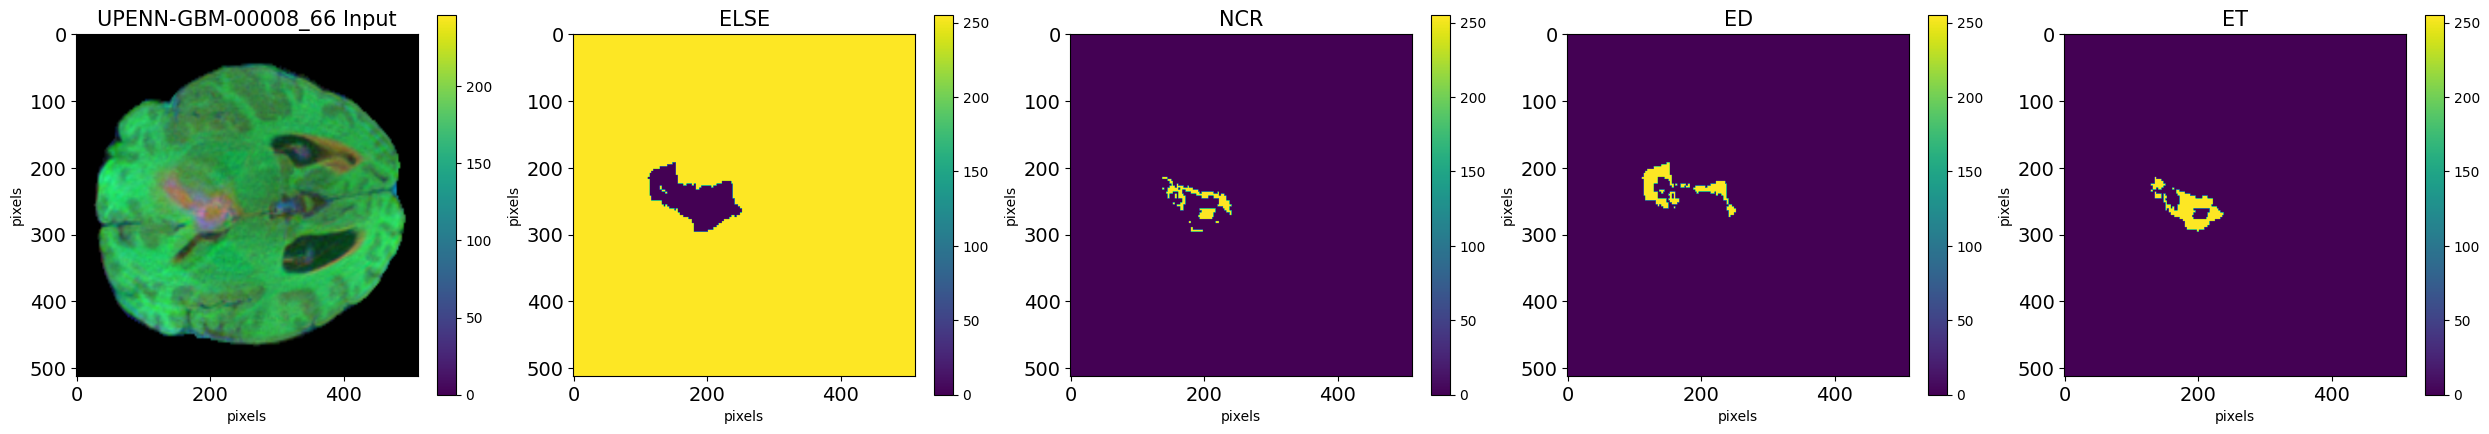

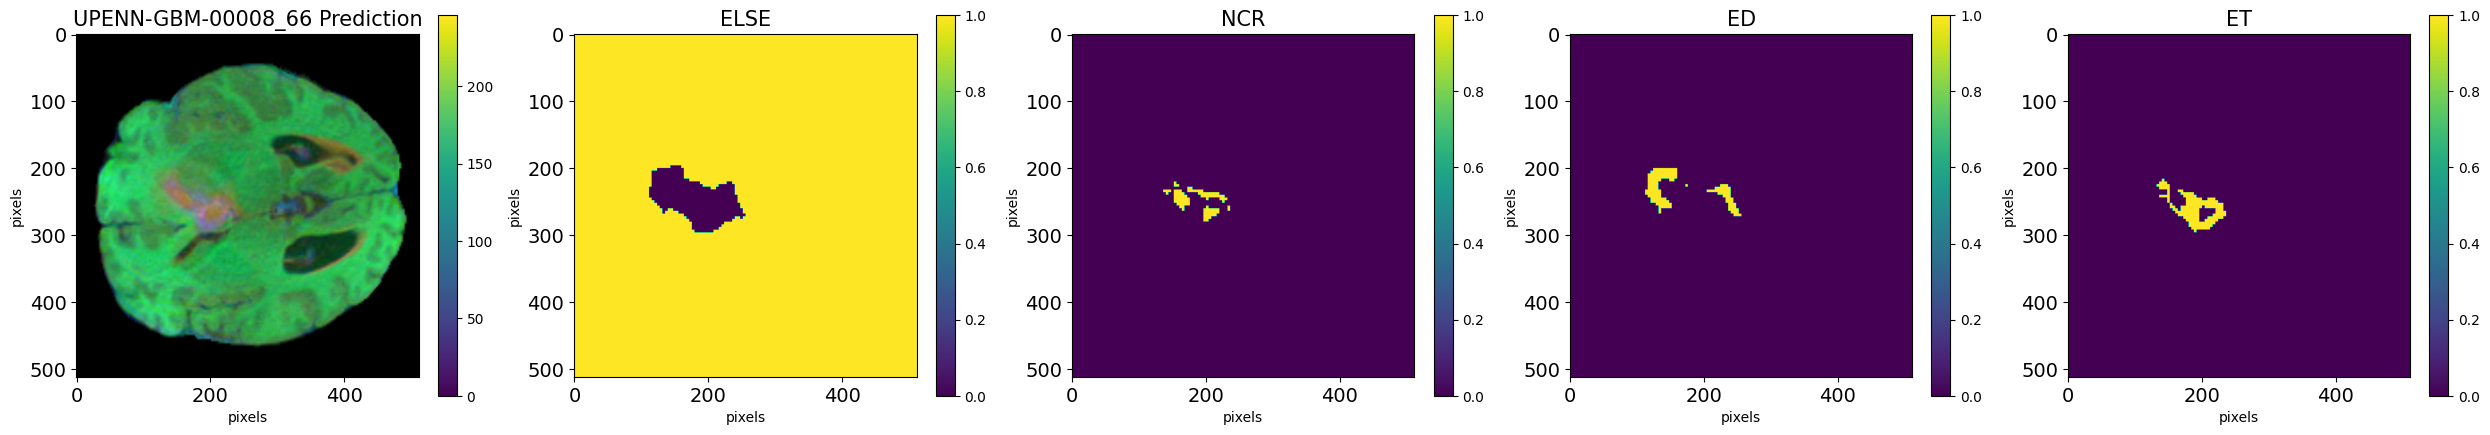

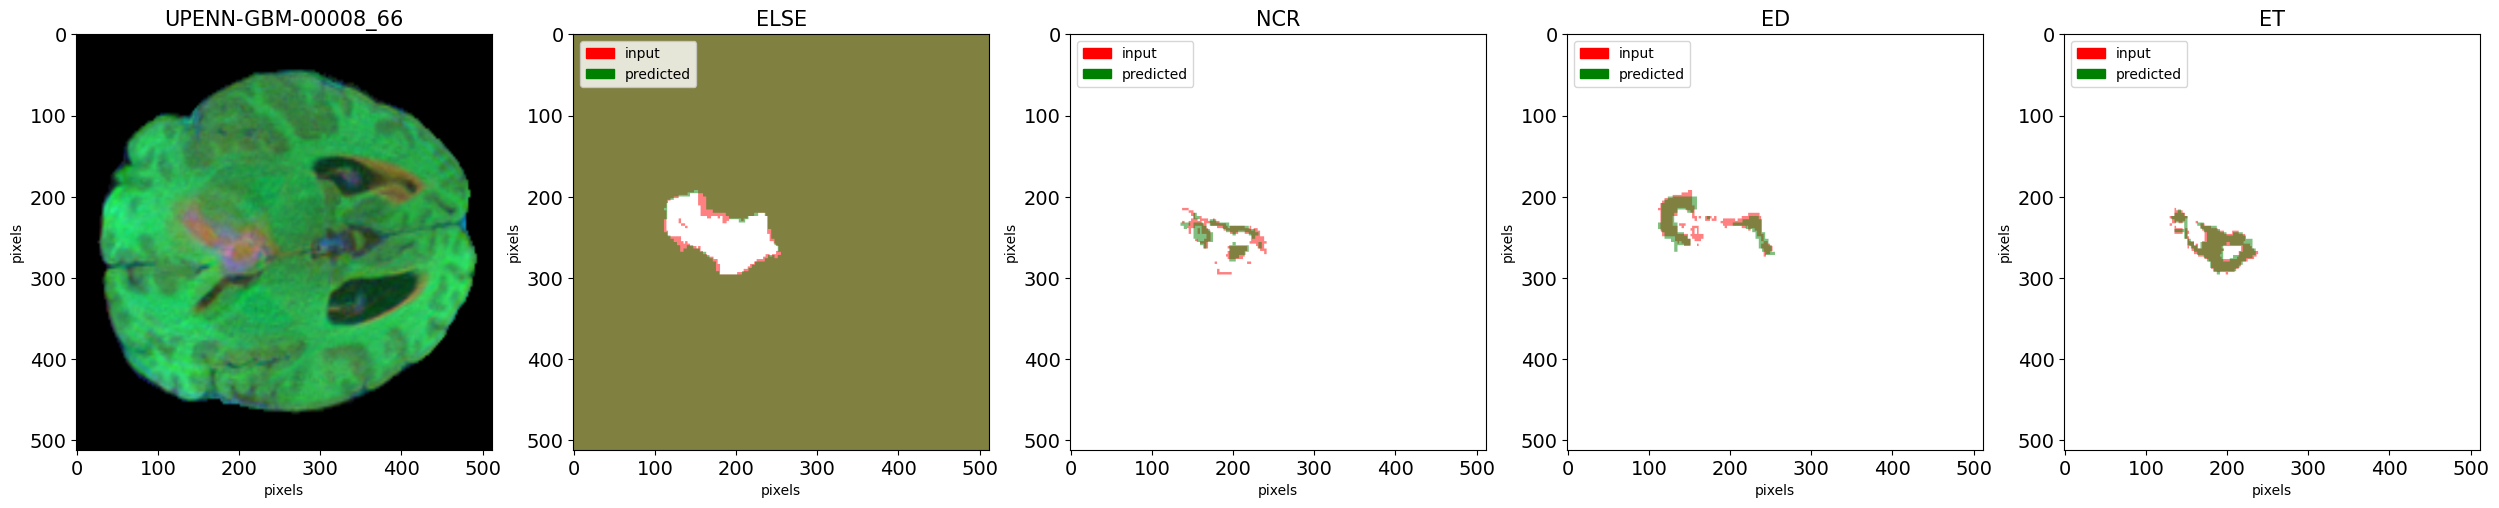

In [ ]:
# visual QC predicted masks

# plot input mask labels
input_class_labels = test_class_labels.numpy()
mf_utils.plot_mask_labels(class_labels= input_class_labels,
             pixel_values = test_image.numpy(),
             mask_labels = test_mask_labels,
             title= test_subj + " Input")

# plot predicted mask labels
pred_class_labels = set([item["label_id"] for item in results['segments_info']])
pred_class_labels = sorted(list(pred_class_labels))
pred_mask_labels = mf_inf.get_mask_from_segm(segm_result=results)
mf_utils.plot_mask_labels(class_labels=pred_class_labels,
             pixel_values = test_image.numpy(),
             mask_labels = pred_mask_labels,
             title= test_subj + " Prediction")

mf_utils.plot_mask_comparison(input_class_labels=input_class_labels,
                     pred_class_labels=pred_class_labels,
                     input_pixel_values=test_image.numpy(),
                     input_mask_labels=test_mask_labels,
                     pred_mask_labels=pred_mask_labels,
                     title=test_subj)


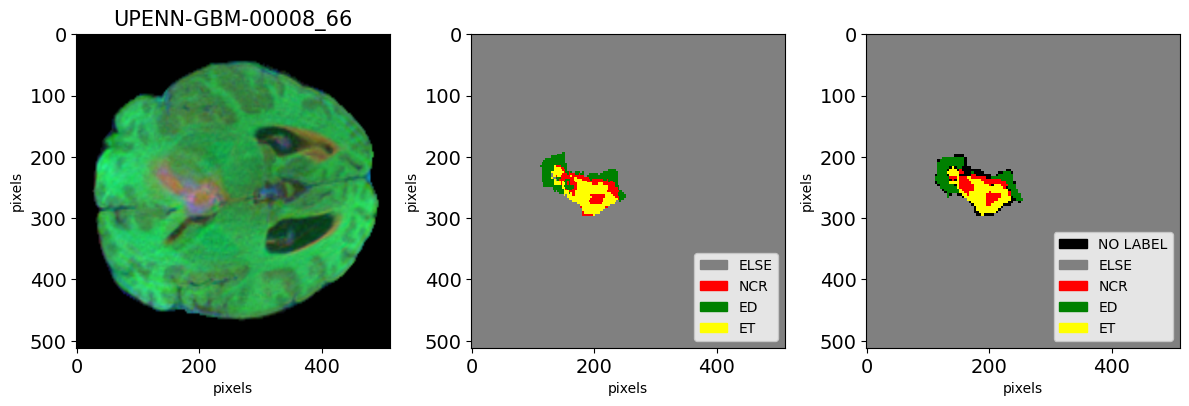

In [ ]:
input_segmentation = mf_utils.input_mask_to_segmentation(input_mask_labels=test_mask_labels, class_labels=input_class_labels)
pred_segmentation = mf_utils.post_proc_result_to_segmentation(results)

mf_utils.plot_segmentation_comparison(
        input_pixel_values=test_image.numpy(),
        input_segmentation=input_segmentation,
        pred_segmentation=pred_segmentation,
        title=test_subj)

#### 4.1.4 Calculate metrics

In [ ]:
print("True mask label", test_mask_labels.numpy().shape)
print("Pred mask label", pred_mask_labels.shape)

True mask label (4, 512, 512)
Pred mask label (4, 512, 512)


In [ ]:
input_class_labels = test_class_labels.numpy()

pred_class_labels.sort()
pred_class_labels.sort()

pred_mask_idx = 0
for true_mask_idx, label_id in enumerate(input_class_labels):

    print(f"Metrics for {id2label[label_id]}:")
    true_mask = test_mask_labels[true_mask_idx, :, :].numpy().squeeze().astype(np.uint8)
    pred_mask = np.zeros(true_mask.shape, dtype=np.uint8)

    if label_id in pred_class_labels:
        pred_scaled_mask = pred_mask_labels[pred_mask_idx, :, :]
        pred_mask = mf_utils.descale_mask(pred_scaled_mask)
        pred_mask_idx+=1

    other_metrics = metrics.calc_binary_metrics(pred_mask, true_mask)

    print("Specificity", other_metrics["specificity"])
    print("Sensitivity", other_metrics["sensitivity"])
    print("Precision", other_metrics["precision"])
    print("Recall", other_metrics["recall"])

    dice_score = metrics.calc_dice_score(pred_mask, true_mask)
    print("Dice Score", dice_score)

    hd95 = metrics.calc_hausdorff_95(pred_mask, true_mask)
    print("HD95", hd95)
    print()

Metrics for ELSE:
Specificity 0.9703947368421053
Sensitivity 0.9956993972877951
Precision 0.9991494991494991
Recall 0.9956993972877951
Dice Score 0.9974214647338134
HD95 4.0

Metrics for NCR:
Specificity 0.9979419681081849
Sensitivity 0.569077013521458
Precision 0.6436170212765957
Recall 0.569077013521458
Dice Score 0.6040561622464898
HD95 13.860514678057351

Metrics for ED:
Specificity 0.9978797633044852
Sensitivity 0.6871120847024461
Precision 0.7738486842105263
Recall 0.6871120847024461
Dice Score 0.7279056275381938
HD95 12.0

Metrics for ET:
Specificity 0.9985884421955509
Sensitivity 0.8410364145658263
Precision 0.8677745664739884
Recall 0.8410364145658263
Dice Score 0.8541963015647226
HD95 3.605551275463989



### 4.2 Make predictions on all data and compute metrics

#### 4.2.1  Obtain data list for Validation data

In [ ]:
# Obtain full train val dataset
# UPENN-GBM-00006_11_FLAIR_1.nii.gz, UPENN-GBM-00006_11_T1_1.nii.gz, UPENN-GBM-00006_11_FLAIR_2.nii.gz...
val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D)

# val_files: unique slices per subj: UPENN-GBM-00006_1.nii.gz, UPENN-GBM-00006_2.nii.gz
val_files = [mri_common.get_mri_slice_file_name(val_file) for val_file in val_2d]
val_files = list(set(val_files))
print("all files in the validation folder")
print(val_files[:10])

# get unique subj_ids: UPENN-GBM-00008, UPENN-GBM-00013 ...
val_subjs = [mri_common.get_mri_subj(val_file) for val_file in val_files]
val_subjs = sorted(list(set(val_subjs)))

print("total validation data", len(val_subjs))
print("first 10 validation subjects")
print(val_subjs[:10])

all files in the validation folder
['UPENN-GBM-00240_94.nii.gz', 'UPENN-GBM-00124_98.nii.gz', 'UPENN-GBM-00101_120.nii.gz', 'UPENN-GBM-00033_75.nii.gz', 'UPENN-GBM-00206_80.nii.gz', 'UPENN-GBM-00144_52.nii.gz', 'UPENN-GBM-00259_10.nii.gz', 'UPENN-GBM-00020_77.nii.gz', 'UPENN-GBM-00474_42.nii.gz', 'UPENN-GBM-00259_88.nii.gz']
total validation data 30
first 10 validation subjects
['UPENN-GBM-00008', 'UPENN-GBM-00013', 'UPENN-GBM-00020', 'UPENN-GBM-00030', 'UPENN-GBM-00033', 'UPENN-GBM-00054', 'UPENN-GBM-00075', 'UPENN-GBM-00086', 'UPENN-GBM-00100', 'UPENN-GBM-00101']


#### 4.2.2 Calculate Metrics for Validation Data

In [ ]:
mf_eval=MaskFormerEvaluation(use_brats_region=True)

print("val metrics_file_name: ", val_metrics_file_name)
val_metrics_dict, val_error_files, val_success_files = mf_eval.predict_and_eval(subj_file_names = val_files,
                                                                                subj_names=val_subjs,
                                                                                data_handler=data_handler,
                                                                                mf_inference=mf_inference,
                                                                                data_identifier=MriType.VAL_2D,
                                                                                metrics_dir_prefix=metrics_dir_prefix,
                                                                                metrics_file_name=val_metrics_file_name,
                                                                                recalculate=RECALCULATE_VAL_METRICS)

val metrics_file_name:  metrics_val_all_aug_20epoch_jul14.joblib
Performing inference on UPENN-GBM-00008
new shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00008
Performing inference on UPENN-GBM-00013
new shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00013
Performing inference on UPENN-GBM-00020
new shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00020
Performing inference on UPENN-GBM-00030
new shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00030
Performing inference on UPENN-GBM-00033
new shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00033
Files with error: []
No. of files after removing problematic images: 5
max hausdorff 8.602325267042627
indices with invalid hd95 []
Files with error: []
Total Files evaluated: 5


#### 4.2.3 Evaluate Validation Data

##### Summary statistics

In [ ]:
mf_eval.display_statistics(val_metrics_dict)

Summary: precision
           ELSE        WT        TC        ET
count  5.000000  5.000000  5.000000  5.000000
mean   0.999490  0.935412  0.941109  0.893406
std    0.000273  0.026436  0.039531  0.060074
min    0.999046  0.891768  0.888368  0.811015
25%    0.999489  0.929640  0.910077  0.864465
50%    0.999550  0.948312  0.958605  0.903489
75%    0.999578  0.950193  0.972882  0.915901
max    0.999788  0.957145  0.975615  0.972158


Summary: recall
           ELSE        WT        TC        ET
count  5.000000  5.000000  5.000000  5.000000
mean   0.997141  0.904250  0.912686  0.865748
std    0.001621  0.030895  0.008052  0.041157
min    0.995260  0.856977  0.905097  0.819476
25%    0.995966  0.895655  0.905999  0.828743
50%    0.997273  0.910010  0.910030  0.877875
75%    0.997802  0.918790  0.919329  0.884194
max    0.999407  0.939815  0.922973  0.918452


Summary: sensitivity
           ELSE        WT        TC        ET
count  5.000000  5.000000  5.000000  5.000000
mean   0.997141  0.9

Final report metric summary

In [ ]:
val_mean_scores = mf_eval.get_mean_scores(val_metrics_dict)
val_mean_scores

ELSE        WT        TC        ET
dice_score   0.998314  0.919471  0.926435  0.879243
hd95         0.965685  4.076419  3.520465  2.000000
sensitivity  0.997141  0.904250  0.912686  0.865748
specificity  0.969061  0.998865  0.999851  0.999766

Box plots

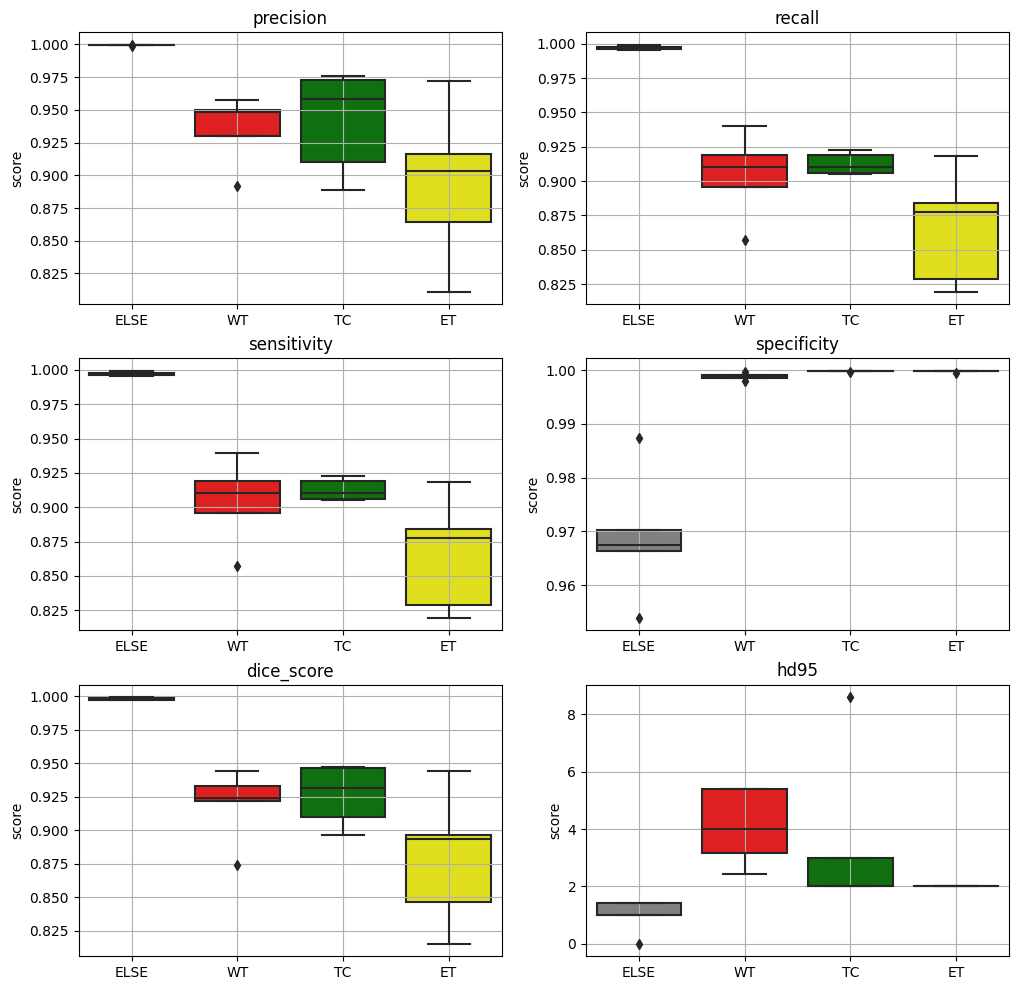

In [ ]:
mf_eval.draw_box_plots(val_metrics_dict)

Histograms

In [ ]:
mf_eval.build_histogram(val_metrics_dict)

##### Worst Dice Score

In [ ]:
low_dice_score_val = mf_eval.get_low_dice_score_images(val_success_files, val_metrics_dict, top_n=15)
low_dice_score_val

subj_name  dataset_idx  label_id     score
0   UPENN-GBM-00020            2         3  0.815224
1   UPENN-GBM-00030            3         3  0.846227
2   UPENN-GBM-00033            4         1  0.874026
3   UPENN-GBM-00033            4         3  0.893738
4   UPENN-GBM-00008            0         3  0.896485
5   UPENN-GBM-00020            2         2  0.896654
6   UPENN-GBM-00033            4         2  0.910053
7   UPENN-GBM-00013            1         1  0.922118
8   UPENN-GBM-00020            2         1  0.924183
9   UPENN-GBM-00030            3         2  0.931560
10  UPENN-GBM-00030            3         1  0.932983
11  UPENN-GBM-00008            0         1  0.944045
12  UPENN-GBM-00013            1         3  0.944542
13  UPENN-GBM-00008            0         2  0.946636
14  UPENN-GBM-00013            1         2  0.947270

##### Worst HD95

In [ ]:
high_hd95_val = mf_eval.get_high_hd95_images(val_subjs, val_metrics_dict, top_n=10)
high_hd95_val

subj_name  dataset_idx  label_id     score
0  UPENN-GBM-00008            0         2  8.602325
1  UPENN-GBM-00030            3         1  5.385165
2  UPENN-GBM-00008            0         1  5.385165
3  UPENN-GBM-00013            1         1  4.000000
4  UPENN-GBM-00033            4         1  3.162278
5  UPENN-GBM-00030            3         2  3.000000
6  UPENN-GBM-00020            2         1  2.449490
7  UPENN-GBM-00008            0         3  2.000000
8  UPENN-GBM-00013            1         3  2.000000
9  UPENN-GBM-00013            1         2  2.000000

##### Plot image with low hausdorff

UPENN-GBM-00008
Slice 96


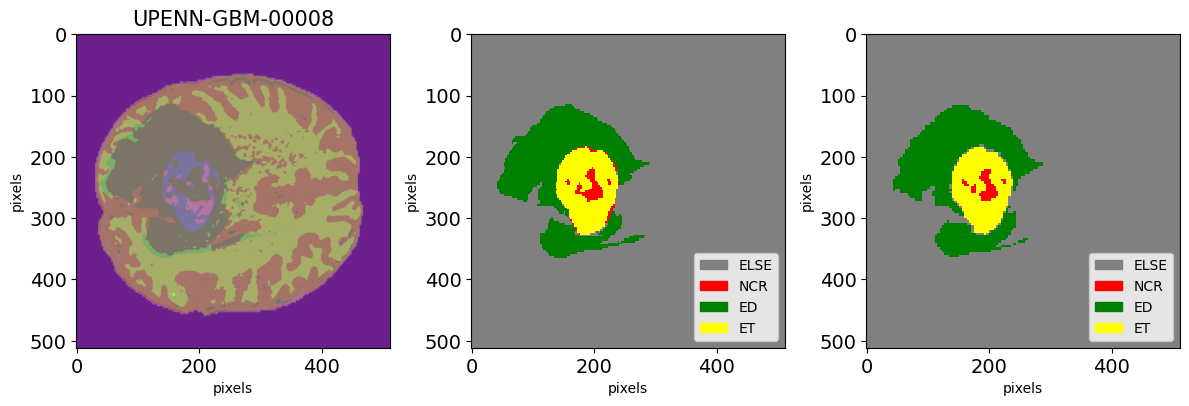

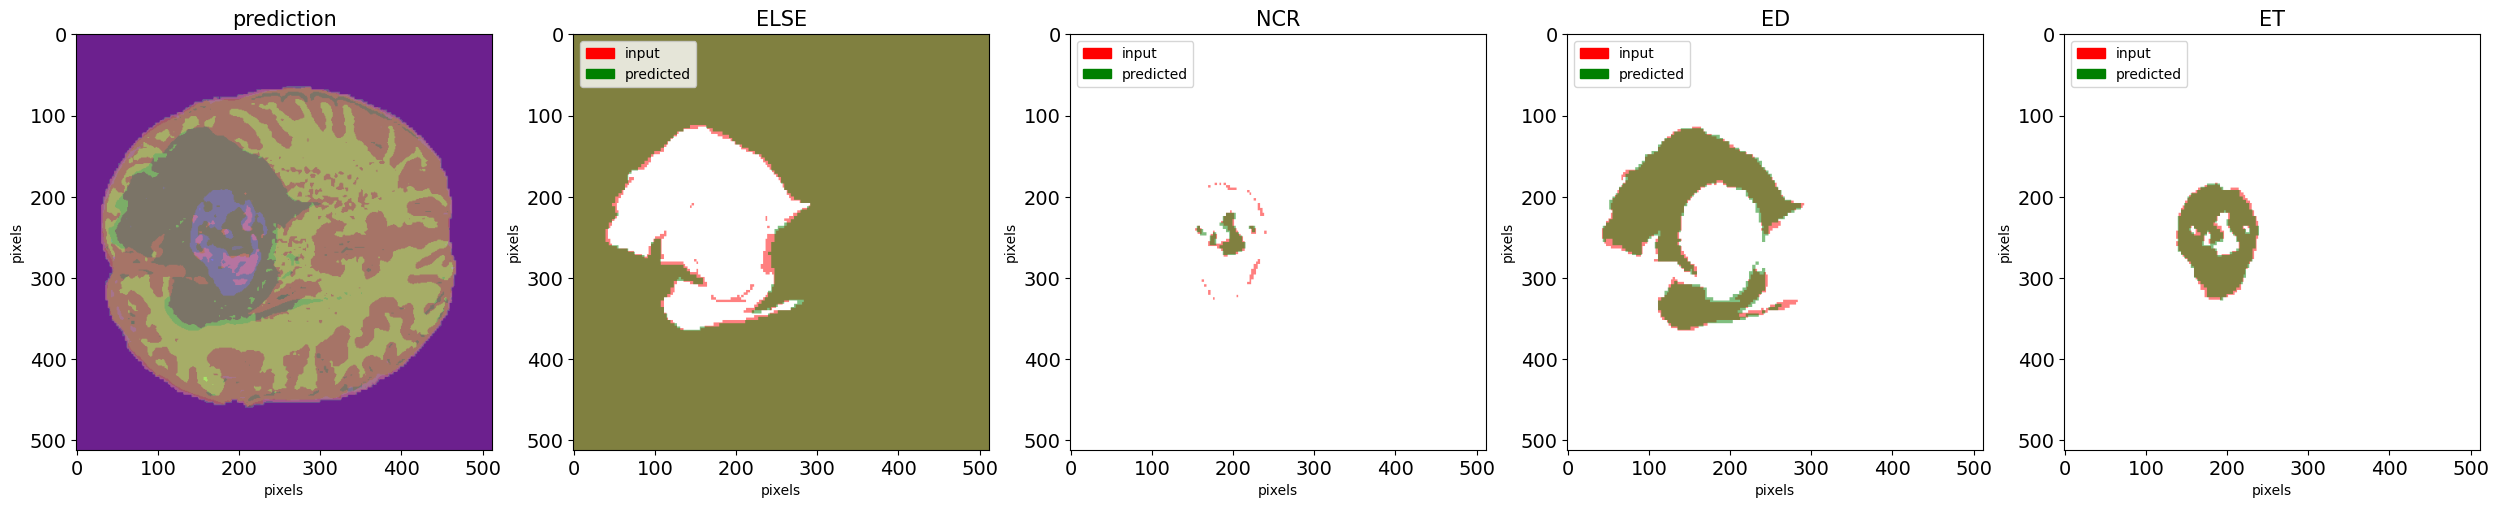

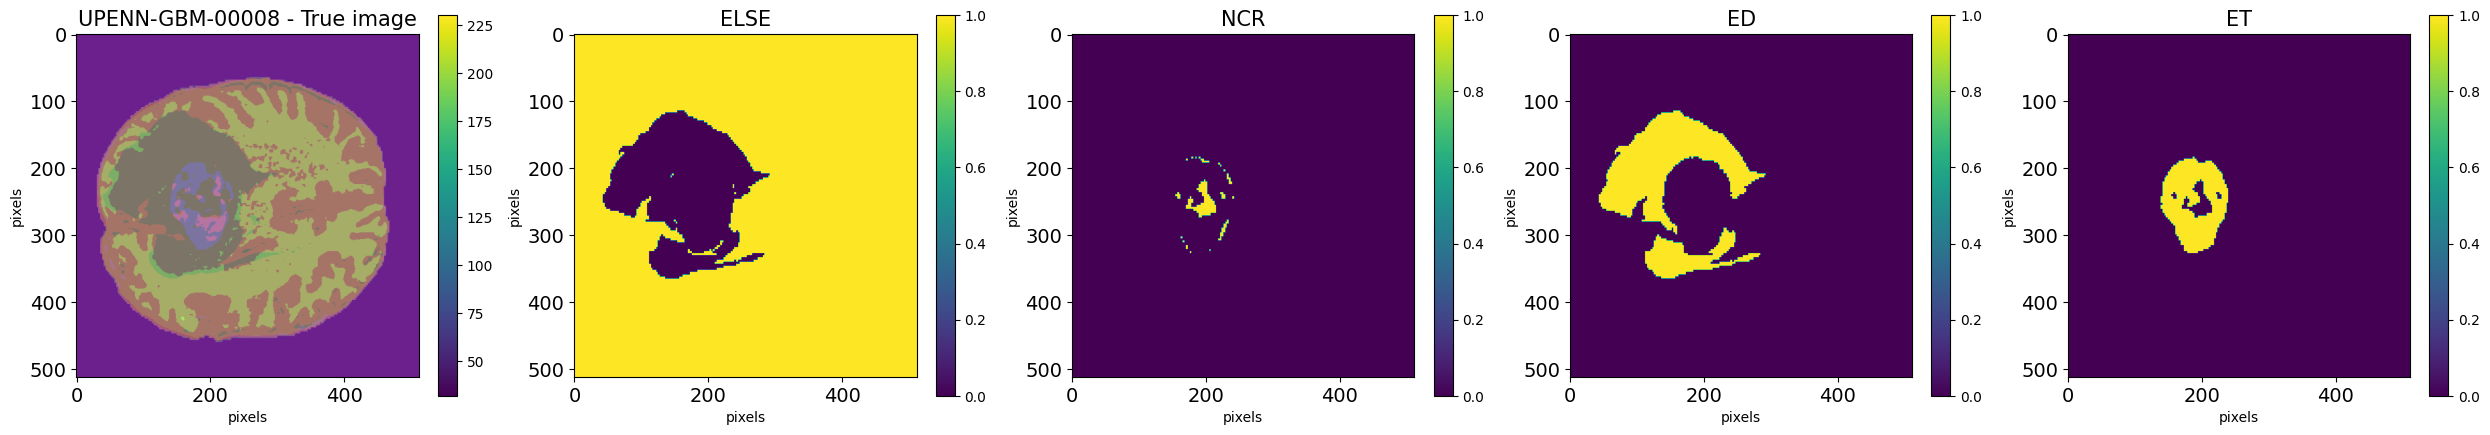

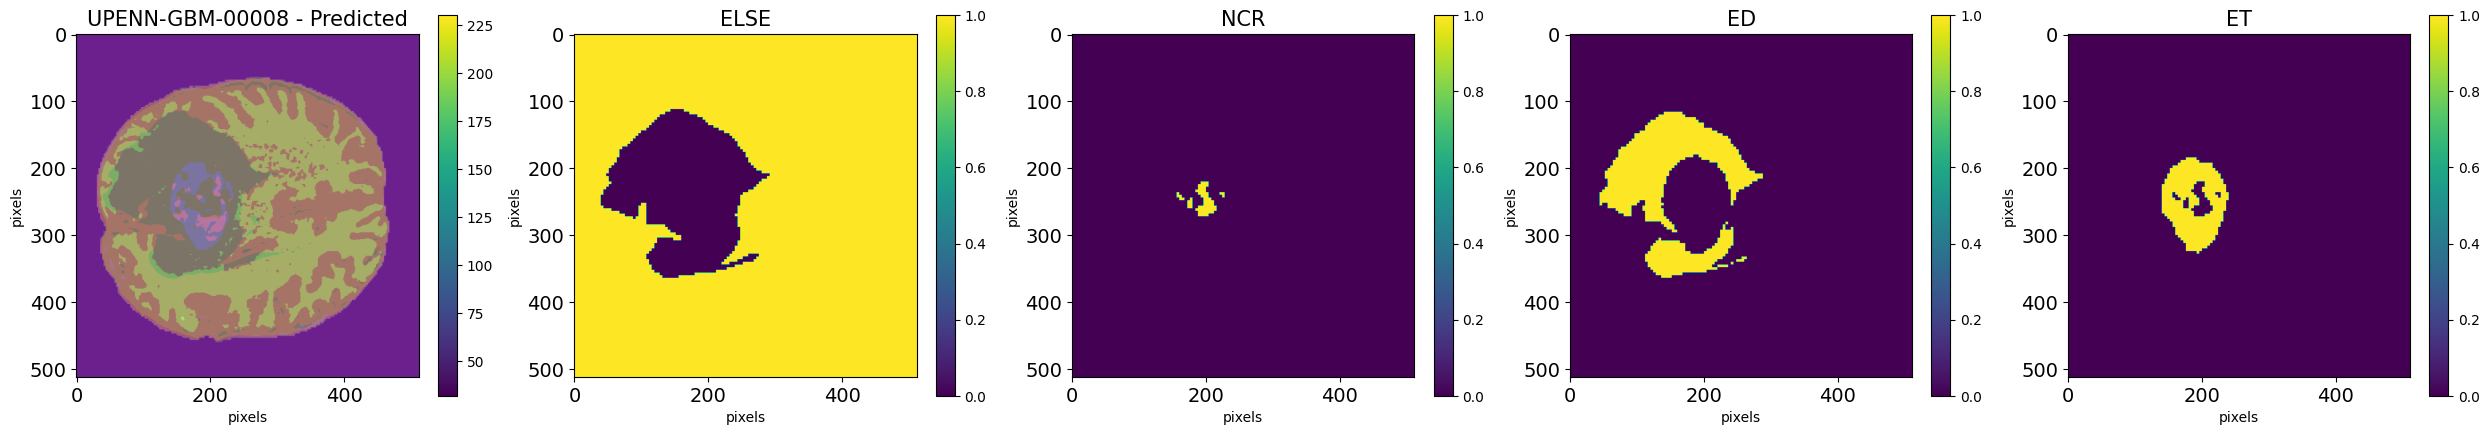

In [ ]:
img2 = high_hd95_val.loc[0]['subj_name']
print(img2)
vol_slices_list = mf_utils.get_patient_slices(file_list=val_files, subj=img2)
image_3d, mask_true_3d, mask_pred_3d, true_class_labels, pred_class_labels = mf_inference.predict_3d_mask(data_list=vol_slices_list, data_identifier=MriType.VAL_2D)

input_segmentation = mf_utils.input_mask_to_segmentation(input_mask_labels=mask_true_3d, class_labels=true_class_labels)
pred_segmentation = mf_utils.input_mask_to_segmentation(input_mask_labels=mask_pred_3d, class_labels=pred_class_labels)
slice_idx = mri_common.get_largest_tumor_slice_idx(input_segmentation.transpose(1,2,0))[0]
print("Slice", slice_idx)

mf_utils.plot_segmentation_comparison(
            input_pixel_values=image_3d[slice_idx, :, :, :],
            input_segmentation=input_segmentation[slice_idx, :, : ],
            pred_segmentation=pred_segmentation[slice_idx, :, : ],
            title=img2)

mf_utils.plot_mask_comparison(input_class_labels=true_class_labels,
                     pred_class_labels=pred_class_labels,
                     input_pixel_values = image_3d[slice_idx, :, :, :],
                     input_mask_labels = mask_true_3d[:, slice_idx, :, :],
                     pred_mask_labels = mask_pred_3d[:, slice_idx, :, :],
                     scale=False,
                     title="prediction")

mf_utils.plot_mask_labels(class_labels = true_class_labels,
             pixel_values = image_3d[slice_idx, :, :, :],
             mask_labels = mask_true_3d[:, slice_idx, :, :],
             title = f"{img2} - True image")

mf_utils.plot_mask_labels(class_labels = pred_class_labels,
             pixel_values = image_3d[slice_idx, :, :, :],
             mask_labels = mask_pred_3d[:, slice_idx, :, :],
             title = f"{img2} - Predicted")

#### 4.2.4 Obtain data list for Training data

In [ ]:
# Obtain full train list dataset
train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D)
train_files = list(set([mri_common.get_mri_slice_file_name(train_file) for train_file in train_2d]))
print(train_files[:10])

# get unique subj_ids
train_subjs = [mri_common.get_mri_subj(train_file) for train_file in train_files]
train_subjs = sorted(list(set(train_subjs)))
print("total training data", len(train_subjs))
print("first 10")
print(train_subjs[:10])

['UPENN-GBM-00344_12.nii.gz', 'UPENN-GBM-00376_13.nii.gz', 'UPENN-GBM-00011_35.nii.gz', 'UPENN-GBM-00391_75.nii.gz', 'UPENN-GBM-00393_132.nii.gz', 'UPENN-GBM-00041_123.nii.gz', 'UPENN-GBM-00114_76.nii.gz', 'UPENN-GBM-00083_86.nii.gz', 'UPENN-GBM-00119_19.nii.gz', 'UPENN-GBM-00134_75.nii.gz']
total training data 88
first 10
['UPENN-GBM-00006', 'UPENN-GBM-00009', 'UPENN-GBM-00011', 'UPENN-GBM-00016', 'UPENN-GBM-00017', 'UPENN-GBM-00018', 'UPENN-GBM-00021', 'UPENN-GBM-00029', 'UPENN-GBM-00031', 'UPENN-GBM-00035']


#### 4.2.5 Calculate Metrics for Training Data

In [ ]:
mf_eval=MaskFormerEvaluation(use_brats_region=True)

print("train metrics_file_name: ", train_metrics_file_name)
train_metrics_dict, train_error_files, train_success_files = mf_eval.predict_and_eval(subj_file_names=train_files,
                                                                        subj_names=train_subjs,
                                                                        data_handler=data_handler,
                                                                        mf_inference=mf_inference,
                                                                        data_identifier=MriType.TRAIN_2D,
                                                                        metrics_dir_prefix=metrics_dir_prefix,
                                                                        metrics_file_name=train_metrics_file_name,
                                                                        recalculate=RECALCULATE_TRAIN_METRICS)

train metrics_file_name:  metrics_train_all_aug_20epoch_jul14.joblib
Performing inference on UPENN-GBM-00006
new shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00006
Performing inference on UPENN-GBM-00009
new shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00009
Performing inference on UPENN-GBM-00011
new shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00011
Performing inference on UPENN-GBM-00016
new shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00016
Performing inference on UPENN-GBM-00017
new shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00017
Files with error: []
No. of files after removing problematic images: 5
max hausdorff 12.041594578792296
indices with invalid hd95 []
Files with error: []
Total Files evaluated: 5


#### 4.2.6 Evaluate Training Data

##### Summary statistics

In [ ]:
mf_eval.display_statistics(train_metrics_dict)

Summary: precision
           ELSE        WT        TC        ET
count  5.000000  5.000000  5.000000  5.000000
mean   0.999489  0.911301  0.940603  0.821360
std    0.000340  0.059487  0.029626  0.083560
min    0.998908  0.818441  0.893474  0.717321
25%    0.999487  0.888593  0.930773  0.751073
50%    0.999606  0.932512  0.951193  0.850704
75%    0.999687  0.950896  0.962101  0.873923
max    0.999756  0.966060  0.965475  0.913777


Summary: recall
           ELSE        WT        TC        ET
count  5.000000  5.000000  5.000000  5.000000
mean   0.997271  0.894019  0.913187  0.824140
std    0.000979  0.041766  0.022532  0.081759
min    0.996274  0.829561  0.885141  0.697233
25%    0.996341  0.889215  0.907170  0.805521
50%    0.997238  0.896709  0.908834  0.826300
75%    0.998087  0.910323  0.917379  0.894369
max    0.998413  0.944285  0.947413  0.897277


Summary: sensitivity
           ELSE        WT        TC        ET
count  5.000000  5.000000  5.000000  5.000000
mean   0.997271  0.8

##### Box plots

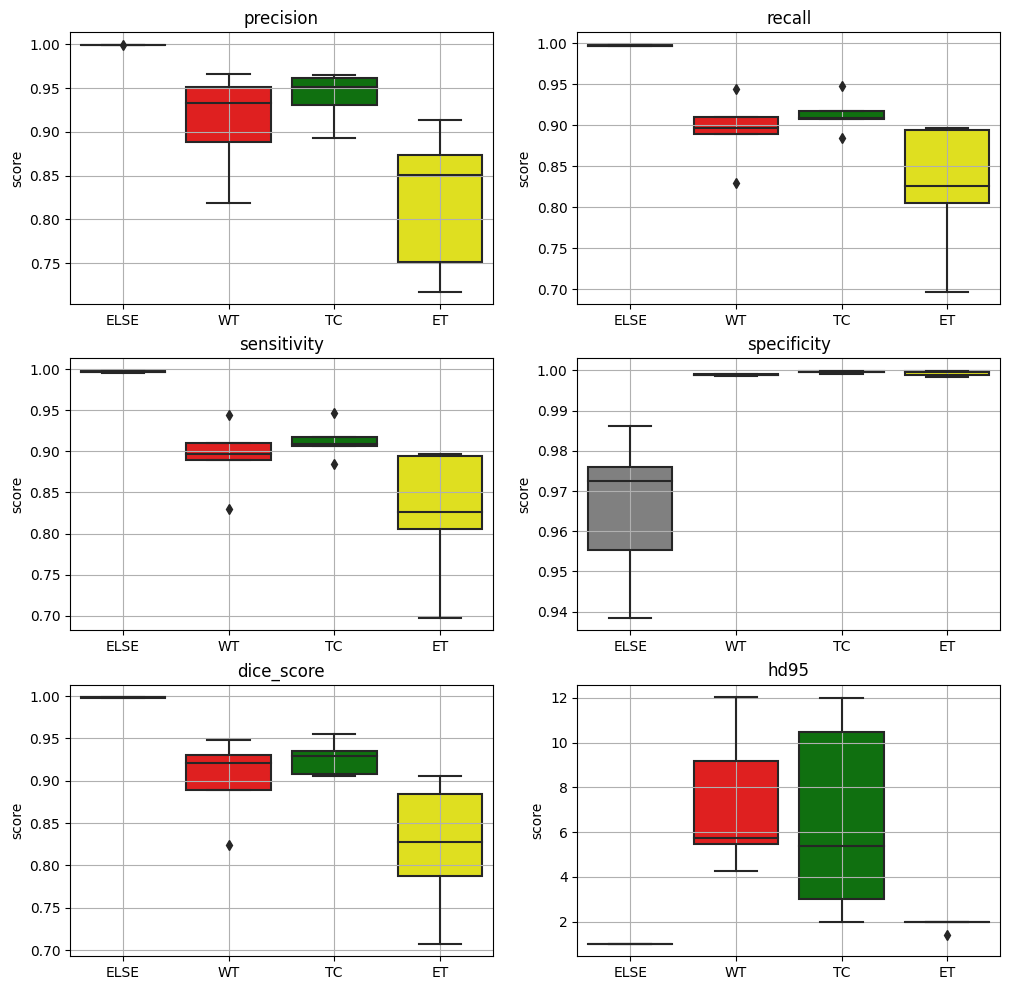

In [ ]:
mf_eval.draw_box_plots(train_metrics_dict)

##### Histograms

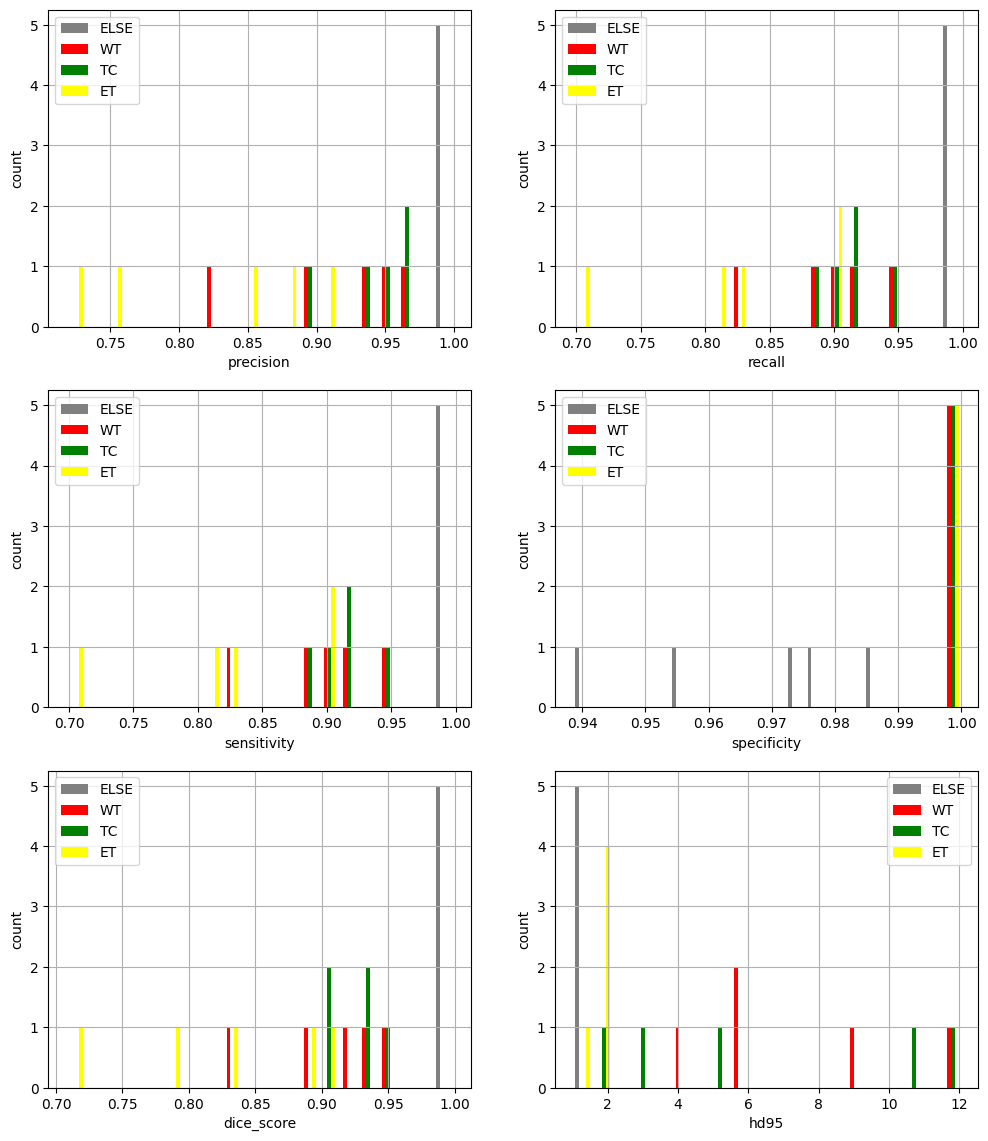

In [ ]:
mf_eval.build_histogram(train_metrics_dict)

##### Worst Dice Score

In [ ]:
low_dice_score_train = mf_eval.get_low_dice_score_images(train_success_files, train_metrics_dict, top_n=15)
low_dice_score_train

subj_name  dataset_idx  label_id     score
0   UPENN-GBM-00017            4         3  0.707134
1   UPENN-GBM-00016            3         3  0.786893
2   UPENN-GBM-00016            3         1  0.823963
3   UPENN-GBM-00011            2         3  0.827496
4   UPENN-GBM-00006            0         3  0.884028
5   UPENN-GBM-00011            2         1  0.888904
6   UPENN-GBM-00016            3         2  0.905269
7   UPENN-GBM-00009            1         3  0.905452
8   UPENN-GBM-00011            2         2  0.907384
9   UPENN-GBM-00009            1         1  0.921284
10  UPENN-GBM-00009            1         2  0.929531
11  UPENN-GBM-00017            4         1  0.930094
12  UPENN-GBM-00017            4         2  0.935414
13  UPENN-GBM-00006            0         1  0.947579
14  UPENN-GBM-00006            0         2  0.954700

##### Worst HD95

In [ ]:
high_hd95_train = mf_eval.get_high_hd95_images(train_success_files, train_metrics_dict, top_n=15)
high_hd95_train

subj_name  dataset_idx  label_id      score
0   UPENN-GBM-00017            4         1  12.041595
1   UPENN-GBM-00017            4         2  12.000000
2   UPENN-GBM-00006            0         2  10.488088
3   UPENN-GBM-00006            0         1   9.165151
4   UPENN-GBM-00009            1         1   5.744563
5   UPENN-GBM-00011            2         1   5.477226
6   UPENN-GBM-00009            1         2   5.385165
7   UPENN-GBM-00016            3         1   4.242641
8   UPENN-GBM-00011            2         2   3.000000
9   UPENN-GBM-00016            3         2   2.000000
10  UPENN-GBM-00011            2         3   2.000000
11  UPENN-GBM-00017            4         3   2.000000
12  UPENN-GBM-00009            1         3   2.000000
13  UPENN-GBM-00006            0         3   2.000000
14  UPENN-GBM-00016            3         3   1.414214